# DSAIT4335 Recommender Systems
# Final Project

In this project, you will work to build different recommendation models and evaluate the effectiveness of these models through offline experiments. The dataset used for the experiments is **MovieLens100K**, a movie recommendation dataset collected by GroupLens: https://grouplens.org/datasets/movielens/100k/. For more details, check the project description on Brightspace.

# Instruction

The MovieLens100K is already splitted into 80% training and 20% test sets. Along with training and test sets, movies metadata as content information is also provided.

**Expected file structure** for this assignment:   
   
   ```
   RecSysProject/
   ├── training.txt
   ├── test.txt
   ├── movies.txt
   └── codes.ipynb
   ```

**Note:** Be sure to run all cells in each section sequentially, so that intermediate variables and packages are properly carried over to subsequent cells.

**Note** Be sure to run all cells such that the submitted file contains the output of each cell.

**Note** Feel free to add cells if you need more for answering a question.

**Submission:** Answer all the questions in this jupyter-notebook file. Submit this jupyter-notebook file (your answers included) to Brightspace. Change the name of this jupyter-notebook file to your group number: example, group10 -> 10.ipynb.

# Setup

In [6]:
!pip install -q transformers torch  # For BERT
!pip install numpy pandas matplotlib seaborn scipy scikit-learn torch tqdm

# you can refer https://huggingface.co/docs/transformers/en/model_doc/bert for various versions of the pre-trained model BERT

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached contourpy-1.3.3-cp313-cp313-macosx_11_0_arm64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-macosx_11_0_arm64.whl.metadata (6.3 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 11.5 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 11.4 MB/s eta 0:00:00a 0:00:01
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 11.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 11.1 MB/s eta 0:00:00a 0:00:01
Using cached contourpy-1.3.3-cp313-cp313-macosx_11_0_arm64.whl (274 kB)
Using cached cycler-0.12.1-py3-n

In [25]:
# For BERT embeddings (install: pip install transformers torch)
print("Check the status of BERT installation:")

try:
    from transformers import AutoTokenizer, AutoModel
    import torch
    BERT_AVAILABLE = True
    print("BERT libraries loaded successfully!")
    device = torch.device('cuda' if torch.cuda.is_available() else 'mps')
    print(f"Using device: {device}")
except ImportError:
    BERT_AVAILABLE = False
    print("BERT libraries not available. Install with: pip install transformers torch")

Check the status of BERT installation:
BERT libraries loaded successfully!
Using device: mps


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from scipy.spatial.distance import cosine, correlation
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from collections import defaultdict
import torch
import torch.nn as nn
import torch.optim as optim
import re
import time, math
from tqdm import tqdm
import random
import itertools
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


### Here we set the random seed to 10 in order to ensure reproducibility of the experiments.

In [27]:
SEED = 10

# Python built-in random seed
random.seed(SEED)

# Numpy random seed
np.random.seed(SEED)

# PyTorch random seed (CPU)
torch.manual_seed(SEED)

# PyTorch random seed (GPU, if available)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if using multi-GPU

## Mount Google Drive Folder

In [ ]:
import os

# Use current directory as project root
PROJECT_PATH = os.getcwd()  # e.g. /Users/yourname/Documents/Project-RecSys
OUTPUTS_PATH = os.path.join(PROJECT_PATH, "data")

# Make sure 'data' folder exists
os.makedirs(OUTPUTS_PATH, exist_ok=True)

print("Project Path:", PROJECT_PATH)
print("Data Path:", OUTPUTS_PATH)

Project Path: /Users/kantatanahashi/Documents/master_cs/recommender_systems/Project-RecSys
Data Path: /Users/kantatanahashi/Documents/master_cs/recommender_systems/Project-RecSys/data


In [29]:
%cd $PROJECT_PATH

/Users/kantatanahashi/Documents/master_cs/recommender_systems/Project-RecSys


# Load dataset

In [30]:
# loading the training set and test set
columns_name=['user_id','item_id','rating','timestamp']
train_data = pd.read_csv(f'{PROJECT_PATH}/training.txt', sep='\t', names=columns_name)
test_data = pd.read_csv(f'{PROJECT_PATH}/test.txt', sep='\t', names=columns_name)

# We take 20% of the original training set as validation
train_data, val_data = train_test_split(
    train_data,
    test_size=0.2,         # 20% validation
    random_state=10,       # ensure reproducibility
    shuffle=True           # shuffle before splitting
)

print(f'The training data:')
display(train_data[['user_id','item_id','rating']].head())
print(f'The shape of the training data: {train_data.shape}')
print('--------------------------------')
print(f'The validation data:')
display(val_data[['user_id','item_id','rating']].head())
print(f'The shape of the validation data: {val_data.shape}')
print('--------------------------------')
print(f'The test data:')
display(test_data[['user_id','item_id','rating']].head())
print(f'The shape of the test data: {test_data.shape}')

The training data:


,user_id,item_id,rating
30548,450,482,5
60209,747,179,5
60230,747,211,5
62326,766,176,2
13422,251,429,4


The shape of the training data: (64000, 4)
--------------------------------
The validation data:


,user_id,item_id,rating
43012,561,23,5
7447,131,536,5
79413,936,1199,4
13011,244,249,4
60268,747,357,5


The shape of the validation data: (16000, 4)
--------------------------------
The test data:


,user_id,item_id,rating
0,1,6,5
1,1,10,3
2,1,12,5
3,1,14,5
4,1,17,3


The shape of the test data: (20000, 4)


In [31]:
movies = pd.read_csv(f'{PROJECT_PATH}/movies.txt',names=['item_id','title','genres','description'],sep='\t')
movies.head()

,item_id,title,genres,description
0,1,Toy Story (1995),"Animation, Children's, Comedy","A group of sentient toys, who pretend to be li..."
1,2,GoldenEye (1995),"Action, Adventure, Thriller","In 1986, MI6 agents James Bond and Alec Trevel..."
2,3,Four Rooms (1995),Thriller,"On New Year's Eve, bellhop Sam (Marc Lawrence)..."
3,4,Get Shorty (1995),"Action, Comedy, Drama",Chili Palmer is a Miami-based loan shark and m...
4,5,Copycat (1995),"Crime, Drama, Thriller",After giving a guest lecture on criminal psych...


In [32]:
num_users = train_data['user_id'].max()
num_items = train_data['item_id'].max()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Number of users: {num_users}, Number of items: {num_items}, Using device: {device}')

Number of users: 943, Number of items: 1682, Using device: cpu


# Helper Functions

In [33]:
# Create embeddings of the movie items
def create_bert_embeddings(content):
    """
    Generate BERT embeddings for movie content.

    Args:
        content: Content of items

    Returns:
        numpy.ndarray: BERT embeddings matrix
    """
    if not BERT_AVAILABLE:
        print("BERT libraries not available. Install with: pip install transformers torch")
        return None

    if content is None:
        return None

    if isinstance(content, pd.Series):
        content = content.fillna("").astype(str).tolist()
    elif isinstance(content, np.ndarray):
        content = content.astype(str).tolist()

    model_name = 'distilbert-base-uncased'

    print(f"Loading BERT model: {model_name}")

    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    # Set device (GPU if available)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using cuda or cpu: {device}")
    model.to(device)
    model.eval()

    print(f"Using device: {device}")

    # Generate embeddings in batches
    batch_size = 32  # Adjust based on available memory
    emb = []

    for i in range(0, len(content), batch_size):
        if i % (batch_size * 10) == 0:
            print(f"Processing batch {i//batch_size + 1}/{len(content)//batch_size + 1}")

        batch_texts = content[i:i + batch_size]

        # Tokenize batch
        inputs = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors='pt'
        )

        # Move to device
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Generate embeddings
        with torch.no_grad():
            outputs = model(**inputs)

            # Use [CLS] token embedding (first token)
            batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            emb.extend(batch_embeddings)

    emb = np.array(emb)

    print(f"BERT embeddings generated: {emb.shape}")
    print(f"Embedding dimension: {emb.shape[1]}")

    return emb

## Get the item embeddings and then save them to Google Drive



In [ ]:
# Three diffrent content representation (title + genre, description, title + genre + description)

import os
# Create a subfolder for saved outputs to avoid performing expensive computations multiple times
os.makedirs(OUTPUTS_PATH, exist_ok=True)

# Define the file paths for each of the three embedding arrays
path_titlegenres = os.path.join(OUTPUTS_PATH, "item_emb_titlegenres.npy")
path_description = os.path.join(OUTPUTS_PATH, "item_emb_description.npy")
path_full = os.path.join(OUTPUTS_PATH, "item_emb_full.npy")

if os.path.exists(path_titlegenres):
    print(f"Loading Title+Genres embeddings from: {path_titlegenres} 💾")
    item_emb_titlegenres = np.load(path_titlegenres)
    print("✅ Loaded successfully!")
else:
    print("Computing Title+Genres embeddings... ⏳")
    title_genres = movies["title"] + ' ' + movies["genres"]
    item_emb_titlegenres = create_bert_embeddings(title_genres)
    np.save(path_titlegenres, item_emb_titlegenres)
    print(f"✅ Computed and saved to shared drive for future use!")

if os.path.exists(path_description):
    print(f"\nLoading Description embeddings from: {path_description} 💾")
    item_emb_description = np.load(path_description)
    print("✅ Loaded successfully!")
else:
    print("\nComputing Description embeddings... ⏳")
    item_emb_description = create_bert_embeddings(movies["description"])
    np.save(path_description, item_emb_description)
    print(f"✅ Computed and saved to shared drive for future use!")

if os.path.exists(path_full):
    print(f"\nLoading Full Content embeddings from: {path_full} 💾")
    item_emb_full = np.load(path_full)
    print("✅ Loaded successfully!")
else:
    print("\nComputing Full Content embeddings... ⏳")
    title_genres_description = movies["title"] + ' ' + movies["genres"] + ' ' + movies["description"]
    item_emb_full = create_bert_embeddings(title_genres_description)
    np.save(path_full, item_emb_full)
    print(f"✅ Computed and saved to shared drive for future use!")

print("\n--- Final Embedding Shapes ---")
print(f"Title+Genres: {item_emb_titlegenres.shape}")
print(f"Description:  {item_emb_description.shape}")
print(f"Full Content: {item_emb_full.shape}")

Loading Title+Genres embeddings from: /Users/kantatanahashi/Documents/master_cs/recommender_systems/Project-RecSys/data/item_emb_titlegenres.npy 💾
✅ Loaded successfully!

Loading Description embeddings from: /Users/kantatanahashi/Documents/master_cs/recommender_systems/Project-RecSys/data/item_emb_description.npy 💾
✅ Loaded successfully!

Loading Full Content embeddings from: /Users/kantatanahashi/Documents/master_cs/recommender_systems/Project-RecSys/data/item_emb_full.npy 💾
✅ Loaded successfully!

--- Final Embedding Shapes ---
Title+Genres: (1682, 768)
Description:  (1682, 768)
Full Content: (1682, 768)


In [36]:
# Get item embedding based on item ID (item id starts at 1)
def get_item_emb(item_id, content_type):
    emb = None

    if content_type == "title_genres":
        emb = item_emb_titlegenres[item_id - 1]
    elif content_type == "description":
        emb = item_emb_description[item_id - 1]
    elif content_type == "full":
        emb = item_emb_full[item_id - 1]

    return emb

In [141]:
# Given content type (title+genres, description, or title+genres+description) returns the embeddings and ratings of interacted items by user_id
def get_interacted_items_embs_rating(train_data, user_id, content_type):
    embs, ratings = [], []

    # use train_data to retrieve the item_ids that target user interacted
    items_and_ratings = train_data[train_data["user_id"] == user_id][['item_id', 'rating']]
    item_ids = items_and_ratings['item_id']
    ratings = items_and_ratings['rating'].tolist()

    indices = [i - 1 for i in item_ids]

    if content_type == "title_genres":
        embs = item_emb_titlegenres[indices]
    elif content_type == "description":
        embs = item_emb_description[indices]
    elif content_type == "full":
        embs = item_emb_full[indices]

    return embs, ratings

# given content type (title+genres, description, or title+genres+description) and aggregation method (avg, weighted_avg, avg_pos) returns the representation of a user.
def get_user_emb(train_data, user_id, content_type, aggregation_method):

    emb = []

    # obtain item embeddings and corresponding ratings of the items that the user has interacted with
    item_embs, ratings = get_interacted_items_embs_rating(
        train_data, user_id, content_type
    )

    interacted_ratings = np.array(ratings)

    if aggregation_method == 'avg':
        emb = np.mean(item_embs, axis=0)

    elif aggregation_method == 'weighted_avg':
        emb = np.average(item_embs, axis=0, weights=interacted_ratings)

    elif aggregation_method == 'avg_pos':
        ratings = np.array(ratings)

        # Filter for only positively rated items above 4
        positive_mask = ratings >= 4
        positive_embs = item_embs[positive_mask]

        if len(positive_embs) > 0:
            emb = np.mean(positive_embs, axis=0)
        else:
            emb = np.zeros(item_embs.shape[1])

    return emb

In [38]:
def RMSE(actual_rating, pred_rating):
    # Implement a function that computes RMSE error between actual ratings and predicted ratings.
    # Note that actual_ratings and pred_ratings are lists.

    result = 0.0

    ############# Your code here ############
    result = np.mean((np.array(pred_rating) - np.array(actual_rating))**2)**(1/2)
    #########################################

    return result

# Task 1) Implementation of different recommendation models as well as a hybrid model combining those recommendation models

In [142]:
device = 'cuda' if torch.cuda.is_available() else 'mps'
print(f'Using device: {device}')

Using device: mps


## 1.1 Content Based Recommendation model


In [144]:
# compute the predicted rating for a user-item pair
def get_user_item_prediction_content_based(train_data, user_id, item_id, content_type, aggregation_method):
    pred_rating = 0.0

    user_embedding = get_user_emb(train_data, user_id, content_type, aggregation_method)
    item_embedding = get_item_emb(item_id, content_type)

    pred_rating = np.dot(user_embedding, item_embedding)

    return pred_rating

In [145]:
user_id, item_id = 100, 266
content_type, aggregation_method = 'full', 'avg' # alternatives are content_type={title_genres,description,full} and aggregation_method={avg,weighted_avg,avg_pos}
print('Predicted score for user_id=100 and item_id=266 for content type '+content_type+' and aggregation method '+aggregation_method+':')
print(get_user_item_prediction_content_based(train_data, user_id, item_id, content_type, aggregation_method))

Predicted score for user_id=100 and item_id=266 for content type full and aggregation method avg:
143.18022


### Function that generates top-k recommendation list for a target user with user-based recommendataion

In [250]:
def recommend_topk_content_based(train_data, target_user, k, content_type, aggregation_method):
    """
    Generate Top-K recommendations for a target user using Content-based CF.

    Args:
        train_data (pd.DataFrame): ratings data with columns [user_id, item_id, rating]
        target_user (int): user_id of the target user
        k (int): number of items to recommend

    Returns:
        list of (item_id, predicted_score) sorted by score desc
    """
    result = []

    user_rated_items = set(train_data[train_data["user_id"] == target_user]["item_id"])
    all_items = set(train_data["item_id"].unique())
    candidate_items = all_items - user_rated_items

    predictions = []
    for item_id in candidate_items:
        pred_rating = get_user_item_prediction_content_based(
            train_data,
            target_user,
            item_id,
            content_type,
            aggregation_method
        )
        if not np.isnan(pred_rating):  # only keep valid predictions
            predictions.append((item_id, pred_rating))

    ratings = [r for _, r in predictions]
    min_rating, max_rating = min(ratings), max(ratings)

    # print(f"Min predicted rating: {min_rating}, Max predicted rating: {max_rating}")
    # print(predictions[:5])

    if max_rating == min_rating:
        mapped_ratings = [(3.0, i) for i, _ in predictions]
    else:
        mapped_ratings = [
            (
                i,
                1 + (r - min_rating) * 4 / (max_rating - min_rating),
            )
            for i, r in predictions
        ]

    result = sorted(mapped_ratings, key=lambda x: x[1], reverse=True)[:k]

    return result


target_user, k = 1, 50
recommendations = recommend_topk_content_based(train_data, target_user, k, content_type="full", aggregation_method="weighted_avg")
print(
    f"Top-{k} recommendations for user {target_user} with content-based recommendation:"
)
for item, score in recommendations:
    print(f"Item {item}: {score:.4f}")

Top-50 recommendations for user 1 with content-based recommendation:
Item 1640: 5.0000
Item 1573: 4.9456
Item 1423: 4.9108
Item 1397: 4.9056
Item 1103: 4.8623
Item 1208: 4.8320
Item 403: 4.7619
Item 387: 4.7597
Item 715: 4.7546
Item 1250: 4.7451
Item 385: 4.7150
Item 56: 4.7141
Item 724: 4.7095
Item 781: 4.7066
Item 147: 4.6818
Item 637: 4.6715
Item 916: 4.6684
Item 381: 4.6578
Item 345: 4.6530
Item 1110: 4.6482
Item 450: 4.6460
Item 398: 4.6308
Item 1048: 4.6285
Item 396: 4.6223
Item 1210: 4.6199
Item 893: 4.6151
Item 328: 4.6093
Item 974: 4.6090
Item 405: 4.6011
Item 631: 4.6004
Item 1605: 4.5987
Item 229: 4.5976
Item 228: 4.5894
Item 317: 4.5888
Item 424: 4.5875
Item 771: 4.5612
Item 406: 4.5578
Item 791: 4.5561
Item 803: 4.5549
Item 375: 4.5532
Item 429: 4.5523
Item 507: 4.5511
Item 298: 4.5502
Item 691: 4.5285
Item 751: 4.5280
Item 800: 4.5279
Item 386: 4.5265
Item 327: 4.5254
Item 264: 4.5234
Item 1277: 4.5213


### Computing RMSE of the content-based recommendation model


In [146]:
def evaluate_rating_prediction_content_based(train_data, test_data, content_type, aggregation_method):
    # Create a mapping from user_id to user embedding
    users_emb = {}
    users = list(train_data['user_id'].unique())
    for user in tqdm(users, desc="Creating user embedding mapping"):
        users_emb[user] = get_user_emb(train_data, user, content_type, aggregation_method)


    # I do the same for items
    items = list(train_data['item_id'].unique())
    items_emb = {}
    for item in tqdm(items, desc="Creating item embedding mapping"):
        items_emb[item] = get_item_emb(item, content_type)

    actual_ratings, pred_ratings = [], []

    global_mean_rating = train_data['rating'].mean()

    for index, test_row in tqdm(test_data.iterrows(), total=len(test_data), desc="Processing test data"):
        user_id = test_row["user_id"]
        item_id = test_row["item_id"]

        user_embedding = users_emb.get(user_id)
        item_embedding = items_emb.get(item_id)

        if user_embedding is None or item_embedding is None:
            # Impute the global average rating if we can't predict
            pred_rating = global_mean_rating
        else:
            # Only calculate dot product if we have both embeddings
            pred_rating = np.dot(user_embedding, item_embedding)

        actual_ratings.append(test_row['rating'])
        pred_ratings.append(pred_rating)

    # Given predicted ratings, map them into [1,5] interval using -> 1 + (pred - min_val) * (4 / (max_val - min_val))

    min_rating = min(pred_ratings)
    max_rating = max(pred_ratings)

    mapped_ratings = [1 + (rating - min_rating) * 4 / (max_rating - min_rating) for rating in pred_ratings]


    mae_value, mse_value, rmse_value = 0.0, 0.0, 0.0


    # compute the metrics: MAE, MSE, RMSE
    # mae_value = MAE(actual_ratings, mapped_ratings)
    # mse_value = MSE(actual_ratings, mapped_ratings)
    rmse_value = RMSE(actual_ratings, mapped_ratings)

    return rmse_value

### Use the RMSE loss to find out which combination of content representation and aggregation method works the best for content-recommendation


In [147]:
def hyperparameter_search_content_based(train_data, val_data, content_types, aggregation_methods):
    """
    Perform hyperparameter tuning for content based recommendation. It finds the best combination
    of content representations and aggregation methods

    Args:
        train_data (pd.DataFrame): training set with columns ['user_id', 'item_id', 'rating']
        val_data (pd.DataFrame): validation set with columns ['user_id', 'item_id', 'rating']
        content_types: content types list (title_genres, description, full)
        aggregation_methods: avg, weighted_avg, avg_pos

    Returns:
        dict: {'best_config': (best_content_type, best_aggregation_method), 'best_rmse': float, 'results': list of tuples (k, rmse)}
    """

    print("\n=== Content Based Recommendation Hyperparameter Search ===")
    results = []

    for content_type in content_types:
        for agg_method in aggregation_methods:
          print(f"starting with {content_type} and {agg_method}")
          rmse = evaluate_rating_prediction_content_based(
              train_data,
              val_data,
              content_type,
              agg_method
          )

          results.append({
              'content_type': content_type,
              'aggregation_method': agg_method,
              'RMSE': rmse
          })
          print(f"Config: ({content_type}, {agg_method}) -> RMSE = {rmse:.4f}")

    # Get the best performing combinations as the result of this hyperparameter tuning
    best_result = min(results, key=lambda x: x['RMSE'])
    best_config = (best_result['content_type'], best_result['aggregation_method'])
    best_rmse = best_result['RMSE']

    print(f"Best result was achieved by the config: {best_config}")

    return {
        'best_config': best_config,
        'best_rmse': best_rmse,
        'results': results
    }

In [148]:
import pickle

# Define parameter space
content_types_grid = ['title_genres', 'description', 'full']
aggregation_methods_grid = ['avg', 'weighted_avg', 'avg_pos']

path_content_based_tuning = os.path.join(OUTPUTS_PATH, 'content_based_tuning_results.pkl')

# Run the search or load results
if os.path.exists(path_content_based_tuning):
    print(f"Loading Content-based tuning results from: {path_content_based_tuning} 💾")
    with open(path_content_based_tuning, 'rb') as f:
        content_based_tuning = pickle.load(f)
    print("✅ Loaded successfully!")
else:
    print("Running Content-based hyperparameter search... ⏳")

    content_based_tuning = hyperparameter_search_content_based(
        train_data,
        val_data,
        content_types_grid,
        aggregation_methods_grid
    )

    # Save the results
    with open(path_content_based_tuning, 'wb') as f:
        pickle.dump(content_based_tuning, f)
    print(f"✅ Saved Content-based tuning results to {path_content_based_tuning}")

print("\n--- Content-Based Tuning Results ---")
print(f"Best Config: {content_based_tuning['best_config']}")
print(f"Best Validation RMSE: {content_based_tuning['best_rmse']:.4f}")

rmse_content_based = content_based_tuning['best_rmse']

Loading Content-based tuning results from: /Users/kantatanahashi/Documents/master_cs/recommender_systems/Project-RecSys/data/content_based_tuning_results.pkl 💾
✅ Loaded successfully!

--- Content-Based Tuning Results ---
Best Config: ('full', 'weighted_avg')
Best Validation RMSE: 1.4700


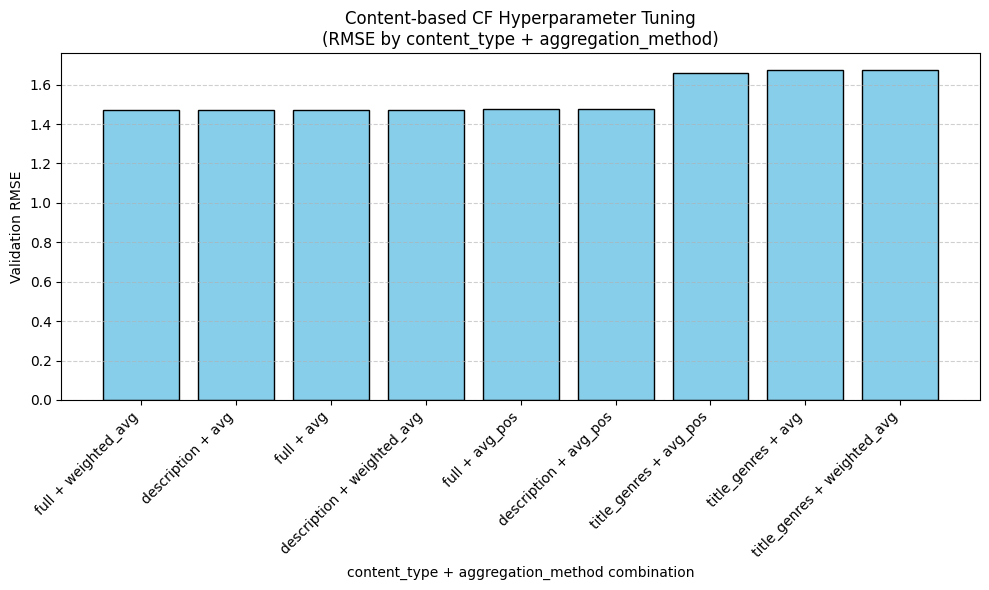

In [149]:
# Visualize Content based recommendation hyperparameter tuning results

results_df = pd.DataFrame(content_based_tuning['results'], columns=['content_type', "aggregation_method", 'RMSE'])
results_df["cobination"] = results_df["content_type"] + " + " + results_df["aggregation_method"]
results_df = results_df.sort_values('RMSE')

plt.figure(figsize=(10, 6))
plt.bar(results_df['cobination'], results_df['RMSE'], color='skyblue', edgecolor='black')

plt.title("Content-based CF Hyperparameter Tuning\n(RMSE by content_type + aggregation_method)", fontsize=12)
plt.xlabel("content_type + aggregation_method combination", fontsize=10)
plt.ylabel("Validation RMSE", fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


## 1.2 User-based neighborhood method (UserKNN)

The **Pearson correlation coefficient** between two users \(x\) and \(y\) is defined as:

$$
r_{xy} = \frac{\sum_{i \in I_{xy}} (x_i - \bar{x})(y_i - \bar{y})}
              {\sqrt{\sum_{i \in I_{xy}} (x_i - \bar{x})^2} \cdot \sqrt{\sum_{i \in I_{xy}} (y_i - \bar{y})^2}}
$$

**Where:**

- $I_{xy}$ = set of items rated by both users  
- $x_i$, $y_i$ = ratings of users \(x\) and \(y\) on item \(i\)  
- $\bar{x}$, $\bar{y}$ = mean ratings of users \(x\) and \(y\) on the common items  



In [ ]:
# define pearson correlation to obtain users similarity
def pearson_correlation(user1_ratings: pd.Series, user2_ratings: pd.Series) -> float:
    # only consider items that have been rated by both users
    common_items = user1_ratings.dropna().index.intersection(user2_ratings.dropna().index)

    if len(common_items) < 2:
        return 0

    u1_ratings = user1_ratings.loc[common_items]
    u2_ratings = user2_ratings.loc[common_items]

    u1_mean = u1_ratings.mean()
    u2_mean = u2_ratings.mean()

    numerator = ((u1_ratings - u1_mean) * (u2_ratings - u2_mean)).sum()
    denominator = np.sqrt(((u1_ratings - u1_mean) ** 2).sum()) * np.sqrt(((u2_ratings - u2_mean) ** 2).sum())

    if denominator == 0:
        return 0.0

    result = numerator / denominator

    if not np.isfinite(result):
        return 0.0

    return result

# compute similarity matrix of size len(users), len(users).
def compute_user_similarity_matrix(train_data: pd.DataFrame) -> pd.DataFrame:
    users = train_data['user_id'].unique()
    user_similarity_matrix = pd.DataFrame(np.zeros((len(users), len(users))), index=users, columns=users)

    for i, usera in enumerate(users):
        for j, userb in enumerate(users):
            if i > j:
                continue
            if usera == userb:
                user_similarity_matrix.loc[usera, userb] = 1
            else:
                sim = pearson_correlation(train_data[train_data["user_id"] == usera].set_index("item_id")["rating"], train_data[train_data["user_id"] == userb].set_index("item_id")["rating"])
                user_similarity_matrix.loc[usera, userb] = sim
                user_similarity_matrix.loc[userb, usera] = sim

    return user_similarity_matrix

# Get top-k most similar users to the target user and return List of tuples: [(neighbor_user_id, similarity), ...] sorted by similarity descending
def get_k_user_neighbors(train_data, user_similarity_matrix: pd.DataFrame, target_user, target_item, k=5):
    top_k_neighbors = []

    # we want to select top k neighbours who have rated the target item
    rated_users = train_data.loc[train_data['item_id'] == target_item, 'user_id'].unique()

    user_similarities = user_similarity_matrix.loc[target_user].drop(target_user)
    # Only keep users who have rated the target item
    user_similarities = user_similarities.loc[user_similarities.index.isin(rated_users)]
    top_k_neighbors = list(user_similarities.nlargest(k).items())

    return top_k_neighbors

In [151]:
# Load similarity matrix from the sahred drive. If not compute and save
path_user_similarity_matrix = os.path.join(OUTPUTS_PATH, "user_similarity_matrix.npy")

if os.path.exists(path_user_similarity_matrix):
    print(f"Loading user similarity matrix from: {path_user_similarity_matrix} 💾")
    user_similarity_matrix = pd.DataFrame(np.load(path_user_similarity_matrix))
    print("✅ Loaded successfully!")
else:
    print("Computing user similarity matrix... ⏳")
    user_similarity_matrix =  compute_user_similarity_matrix(train_data)
    np.save(path_user_similarity_matrix, user_similarity_matrix)
    print(f"✅ Computed and saved to shared drive for future use!")

Computing user similarity matrix... ⏳
✅ Computed and saved to shared drive for future use!


In [179]:
def predict_rating_user_based(
    train_data: pd.DataFrame,
    user_similarity_matrix: pd.DataFrame,
    target_user,
    target_item,
    global_mean_rating, k=5,
):
    """
    Predict rating for target_user and target_item using mean-centered user-based CF.

    Parameters:
    - ratings: pd.DataFrame with columns ['user_id', 'item_id', 'rating']
    - user_similarity_matrix: pd.DataFrame of user-user similarities
    - target_user: user ID
    - target_item: item ID
    - global_mean_rating: global mean rating to use as fallback
    - k: number of neighbors to consider

    Returns:
    - float: predicted rating, or np.nan if not possible
    """
    result = 0.0

    ############# Your code here ############
    user_ratings = train_data[train_data["user_id"] == target_user].set_index("item_id")["rating"]
    item_ratings = train_data[train_data["item_id"] == target_item].set_index("user_id")["rating"]

    user_mean = user_ratings.mean()

    # if user has no rating, fall back to global mean rating
    if pd.isna(user_mean):
        user_mean = global_mean_rating

    # gets top k neighbors who rated the target item
    top_k_neighbors = get_k_user_neighbors(train_data, user_similarity_matrix, target_user, target_item, k)

    # If no neighbors, return user mean
    if not top_k_neighbors:
        return user_mean

    neighbor_ids = [n_id for n_id, similarity in top_k_neighbors]
    neighbour_id_to_mean_rating = train_data[train_data["user_id"].isin(neighbor_ids)].groupby('user_id')['rating'].mean()
    # # global mean for neighbors with no ratings
    # neighbour_id_to_mean_rating = neighbour_id_to_mean_rating.fillna(global_mean_rating)

    numerator = 0.0
    denominator = 0.0

    for neighbour_id, similarity in top_k_neighbors:
        if neighbour_id in item_ratings.index:
            numerator += similarity * (item_ratings.loc[neighbour_id] - neighbour_id_to_mean_rating[neighbour_id])
            denominator += abs(similarity)

    if denominator == 0:
        return user_mean 

    result = user_mean + (numerator/denominator)

    result = np.clip(result, 1, 5)

    #########################################

    return result

In [180]:
target_user, target_item, k = 1, 17, 50
global_mean_rating = train_data["rating"].mean()
print(
    f"The actual rating for user {target_user} and item {target_item} is 3. The predicted rating by user-based CF for user {target_user} and item {target_item} is {predict_rating_user_based(train_data, user_similarity_matrix, target_user, target_item, global_mean_rating, k):.4f}"
)

The actual rating for user 1 and item 17 is 3. The predicted rating by user-based CF for user 1 and item 17 is 3.3509


### Function that generates top-k recommendation list for a target user with user-based recommendataion

In [246]:
def recommend_topk_user_based(train_data, user_similarity_matrix, target_user, k_user, k=5):
    """
    Generate Top-K recommendations for a target user using User-based CF.

    Args:
        train_data (pd.DataFrame): ratings data with columns [user_id, item_id, rating]
        user_similarity_matrix (pd.DataFrame): precomputed user-user similarity matrix
        target_user (int): user_id of the target user
        k (int): number of items to recommend

    Returns:
        list of (item_id, predicted_score) sorted by score desc
    """
    result = []

    user_rated_items = set(train_data[train_data["user_id"] == target_user]["item_id"])
    all_items = set(train_data["item_id"].unique())
    candidate_items = all_items - user_rated_items

    predictions = []
    for item_id in candidate_items:
        pred_rating = predict_rating_user_based(
            train_data,
            user_similarity_matrix,
            target_user,
            item_id,
            global_mean_rating,
            k_user,
        )
        if not np.isnan(pred_rating):  # only keep valid predictions
            predictions.append((item_id, pred_rating))

    result = sorted(predictions, key=lambda x: x[1], reverse=True)[:k]

    return result


target_user, k_user, k = 1, 50, 50
recommendations = recommend_topk_user_based(
    train_data, user_similarity_matrix, target_user, k_user, k
)
print(f"Top-{k} recommendations for user {target_user} with user-based recommendation:")
for item, score in recommendations:
    print(f"Item {item}: {score:.4f}")

Top-50 recommendations for user 1 with user-based recommendation:
Item 74: 5.0000
Item 891: 5.0000
Item 1233: 5.0000
Item 1467: 5.0000
Item 1599: 5.0000
Item 1618: 5.0000
Item 1293: 4.9983
Item 1368: 4.9329
Item 851: 4.8699
Item 1442: 4.8647
Item 1662: 4.8641
Item 1673: 4.8269
Item 1629: 4.8244
Item 1038: 4.8119
Item 1167: 4.8031
Item 1414: 4.7698
Item 1642: 4.7602
Item 1144: 4.7600
Item 1607: 4.7481
Item 793: 4.7234
Item 1631: 4.7051
Item 1645: 4.7051
Item 1650: 4.7051
Item 1656: 4.6965
Item 1512: 4.6906
Item 1449: 4.6672
Item 1367: 4.6660
Item 1189: 4.6474
Item 408: 4.6468
Item 1424: 4.6459
Item 1643: 4.6428
Item 909: 4.6152
Item 483: 4.6146
Item 957: 4.6018
Item 1624: 4.5918
Item 677: 4.5787
Item 360: 4.5726
Item 64: 4.5596
Item 868: 4.5571
Item 1338: 4.5406
Item 1452: 4.5360
Item 272: 4.5343
Item 918: 4.5280
Item 285: 4.5256
Item 12: 4.5209
Item 1122: 4.5181
Item 1256: 4.5103
Item 318: 4.4989
Item 1255: 4.4821
Item 1664: 4.4794


### Computing RMSE of the User based KNN recommendation model



In [182]:
def evaluate_rating_prediction_user_based(train_data, test_data, user_similarity_matrix, k):
    actual_ratings, pred_ratings = [], []
    global_mean_rating = train_data["rating"].mean()


    for index, test_row in tqdm(test_data.iterrows(), total=len(test_data), desc="Processing test data"):
        user_id = test_row["user_id"]
        item_id = test_row["item_id"]

        pred_rating = predict_rating_user_based(train_data, user_similarity_matrix, user_id, item_id, global_mean_rating, k)

        if not np.isnan(pred_rating):
            actual_ratings.append(test_row['rating'])
            pred_ratings.append(pred_rating)

    # Given predicted ratings, map them into [1,5] interval using -> 1 + (pred - min_val) * (4 / (max_val - min_val))

    min_rating = min(pred_ratings)
    max_rating = max(pred_ratings)

    if max_rating == min_rating:
        min_rating = max_rating - 0.001

    mapped_ratings = [1 + (rating - min_rating) * 4 / (max_rating - min_rating) for rating in pred_ratings]

    mae_value, mse_value, rmse_value = 0.0, 0.0, 0.0

    # compute the metrics: MAE, MSE, RMSE
    # mae_value = MAE(actual_ratings, mapped_ratings)
    # mse_value = MSE(actual_ratings, mapped_ratings)
    rmse_value = RMSE(actual_ratings, mapped_ratings)

    return rmse_value

### Use the RMSE loss to find out which combination of content representation and aggregation method works the best for content-recommendation




In [183]:
def hyperparameter_search_user_based(train_data, val_data, user_similarity_matrix, ks):
    """
    Perform hyperparameter tuning for user KNN based recommendation. It finds the best k value

    Args:
        train_data (pd.DataFrame): training set with columns ['user_id', 'item_id', 'rating']
        val_data (pd.DataFrame): validation set with columns ['user_id', 'item_id', 'rating']
        user_similarity_matrix: user similarity matrix
        ks: list of ks to test out

    Returns:
            dict: {'best_k': int, 'best_rmse': float, 'results': list of tuples (k, rmse)}
    """

    print("\n=== User Based Recommendation Hyperparameter Search ===")
    results = []

    for k in ks:
          print(f"Testing k value={k}")
          rmse = evaluate_rating_prediction_user_based(train_data, test_data, user_similarity_matrix, k)

          results.append({
              'k': k,
              'RMSE': rmse,
          })
          print(f"Config: k={k} -> RMSE = {rmse:.4f}")

    # Get the best performing combinations as the result of this hyperparameter tuning
    best_result = min(results, key=lambda x: x['RMSE'])
    best_k = best_result['k']
    best_rmse = best_result['RMSE']
    print(f"\n✅ Best UserKNN config: k={best_k}, RMSE={best_rmse:.4f}")

    return {'best_k': best_k, 'best_rmse': best_rmse, 'results': results}

In [185]:
path_user_knn_tuning = os.path.join(OUTPUTS_PATH, "user_knn_tuning_result.pkl")
ks = [5, 10, 20, 30, 50, 70, 100]

user_knn_tuning = None

if os.path.exists(path_user_knn_tuning):
    print(f"Loading UserKNN tuning results from: {path_user_knn_tuning} 💾")
    with open(path_user_knn_tuning, 'rb') as f:
        user_knn_tuning = pickle.load(f)
    print("✅ Loaded successfully!")
else:
    print("Running UserKNN hyperparameter search... ⏳")
    user_knn_tuning = hyperparameter_search_user_based(train_data, val_data, user_similarity_matrix, ks)
    with open(path_user_knn_tuning, 'wb') as f:
        pickle.dump(user_knn_tuning, f)
    print(f"✅ Saved UserKNN tuning results to {path_user_knn_tuning}")

Running UserKNN hyperparameter search... ⏳

=== User Based Recommendation Hyperparameter Search ===
Testing k value=5


Processing test data: 100%|██████████| 20000/20000 [00:43<00:00, 458.32it/s]


Config: k=5 -> RMSE = 1.0436
Testing k value=10


Processing test data: 100%|██████████| 20000/20000 [00:44<00:00, 446.11it/s]


Config: k=10 -> RMSE = 1.0053
Testing k value=20


Processing test data: 100%|██████████| 20000/20000 [00:48<00:00, 412.36it/s]


Config: k=20 -> RMSE = 0.9862
Testing k value=30


Processing test data: 100%|██████████| 20000/20000 [00:46<00:00, 429.36it/s]


Config: k=30 -> RMSE = 0.9817
Testing k value=50


Processing test data: 100%|██████████| 20000/20000 [00:47<00:00, 421.24it/s]


Config: k=50 -> RMSE = 0.9779
Testing k value=70


Processing test data: 100%|██████████| 20000/20000 [00:54<00:00, 366.11it/s]


Config: k=70 -> RMSE = 0.9790
Testing k value=100


Processing test data: 100%|██████████| 20000/20000 [00:53<00:00, 375.19it/s]

Config: k=100 -> RMSE = 0.9811

✅ Best UserKNN config: k=50, RMSE=0.9779
✅ Saved UserKNN tuning results to /Users/kantatanahashi/Documents/master_cs/recommender_systems/Project-RecSys/data/user_knn_tuning_result.pkl


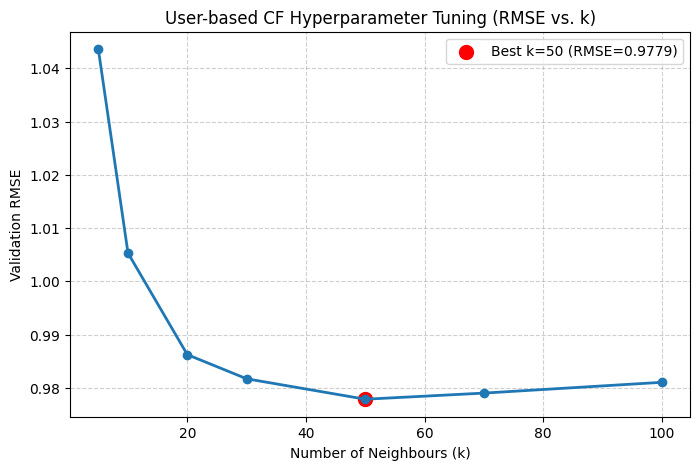

In [186]:
# Visualize UserKNN hyperparameter tuning results

results_df = pd.DataFrame(user_knn_tuning['results'], columns=['k', 'RMSE'])

plt.figure(figsize=(8,5))
plt.plot(results_df['k'], results_df['RMSE'], marker='o', linestyle='-', linewidth=2)
plt.title("User-based CF Hyperparameter Tuning (RMSE vs. k)")
plt.xlabel("Number of Neighbours (k)")
plt.ylabel("Validation RMSE")
plt.grid(True, linestyle='--', alpha=0.6)

# Highlight the best k
best_k = user_knn_tuning['best_k']
best_rmse = user_knn_tuning['best_rmse']
rmse_user_based = best_rmse
plt.scatter(best_k, best_rmse, color='red', s=100, label=f"Best k={best_k} (RMSE={best_rmse:.4f})")
plt.legend()
plt.show()

## 1.3 Item-based neighborhood method (ItemKNN)

The **cosine similarity** between two items \(i\) and \(j\) is defined as:

$$
\text{sim}(i,j) = \frac{\sum_{u \in U_{ij}} r_{u,i} \cdot r_{u,j}}
                      {\sqrt{\sum_{u \in U_{ij}} r_{u,i}^2} \cdot \sqrt{\sum_{u \in U_{ij}} r_{u,j}^2}}
$$

Where:

- \(r_{u,i}\) = rating of user \(u\) on item \(i\)  
- \(r_{u,j}\) = rating of user \(u\) on item \(j\)  
- \(U_{ij}\) = set of users who have rated both items \(i\) and \(j\)  


In [166]:
def cosine_similarity(item1_ratings: pd.Series, item2_ratings: pd.Series) -> float:
    """
    Compute cosine similarity between two items' rating vectors.
    Only common users are considered.

    Parameters:
    - item1_ratings, item2_ratings: pd.Series indexed by user_id

    Returns:
    - float: cosine similarity between -1 and 1
    """
    result = 0.0

    common_users = item1_ratings.index.intersection(item2_ratings.index)
    if len(common_users) == 0:
        return 0.0  # no common users, similarity is 0

    x = item1_ratings[common_users].values
    y = item2_ratings[common_users].values

    numerator = np.dot(x, y)
    denominator = np.sqrt(np.dot(x, x)) * np.sqrt(np.dot(y, y))
    if denominator == 0:
        return 0.0  # avoid division by zero

    result = numerator / denominator

    return result

item1, item2 = 1, 2
item1_ratings = train_data[train_data['item_id'] == item1].set_index('user_id')['rating']
item2_ratings = train_data[train_data['item_id'] == item2].set_index('user_id')['rating']
print(f"Cosine similarity between items {item1} and {item2} is {cosine_similarity(item1_ratings, item2_ratings):.4f}")

Cosine similarity between items 1 and 2 is 0.9545


### Item-Item Similarity Matrix

In [167]:
def compute_item_similarity_matrix(train_data: pd.DataFrame) -> pd.DataFrame:
    """
    Compute item-item similarity matrix using cosine similarity.

    Parameters:
    - ratings: pd.DataFrame with columns ['user_id', 'item_id', 'rating']

    Returns:
    - pd.DataFrame: item-item similarity matrix (rows & cols = item_ids)
    """
    items = train_data['item_id'].unique()
    item_similarity_matrix = pd.DataFrame(np.zeros((len(items), len(items))), index=items, columns=items)

    for i, i1 in enumerate(items):
        i1_ratings = train_data[train_data['item_id'] == i1].set_index('user_id')['rating']
        for j, i2 in enumerate(items):
            if j > i:  # Only compute for the upper triangle
                i2_ratings = train_data[train_data['item_id'] == i2].set_index('user_id')['rating']
                sim = cosine_similarity(i1_ratings, i2_ratings)
                item_similarity_matrix.at[i1, i2] = sim
                item_similarity_matrix.at[i2, i1] = sim  # Mirror the value
            elif i == j:
                item_similarity_matrix.at[i1, i2] = 1.0  # Similarity with self is 1

    return item_similarity_matrix

# start_time = time.time()
# item_similarity_matrix = compute_item_similarity_matrix(train_data)
# end_time = time.time()
# print(f'Running time: {end_time - start_time:.4f} seconds')

In [168]:
path_item_similarity_matrix = os.path.join(OUTPUTS_PATH, "item_similarity_matrix.pkl")

if os.path.exists(path_item_similarity_matrix):
    print(f"Loading item similarity matrix from: {path_item_similarity_matrix} 💾")
    item_similarity_matrix = pd.read_pickle(path_item_similarity_matrix)

    # ensure IDs are int
    item_similarity_matrix.index = item_similarity_matrix.index.astype(int)
    item_similarity_matrix.columns = item_similarity_matrix.columns.astype(int)

    print(f"✅ Loaded successfully with shape {item_similarity_matrix.shape} and item IDs preserved!")
else:
    print("Computing item similarity matrix... ⏳")
    start_time = time.time()
    item_similarity_matrix = compute_item_similarity_matrix(train_data)
    end_time = time.time()

    # ensure IDs are int
    item_similarity_matrix.index = item_similarity_matrix.index.astype(int)
    item_similarity_matrix.columns = item_similarity_matrix.columns.astype(int)

    # save properly with labels
    item_similarity_matrix.to_pickle(path_item_similarity_matrix)
    print(f"✅ Computed and saved to {path_item_similarity_matrix} (took {end_time - start_time:.2f}s)")

Computing item similarity matrix... ⏳
✅ Computed and saved to /Users/kantatanahashi/Documents/master_cs/recommender_systems/Project-RecSys/data/item_similarity_matrix.pkl (took 379.04s)


In [171]:
print("Matrix shape:", item_similarity_matrix.shape)
print("Index dtype:", item_similarity_matrix.index.dtype)
print("Column dtype:", item_similarity_matrix.columns.dtype)
print("Sample item IDs:", item_similarity_matrix.index[:10].tolist())
print("Accessing item 599 row works?", 599 in item_similarity_matrix.index)

Matrix shape: (1615, 1615)
Index dtype: int64
Column dtype: int64
Sample item IDs: [482, 179, 211, 176, 429, 71, 678, 1006, 252, 172]
Accessing item 599 row works? False



Instead of calculating the similarity for all pairs, we only compute it for one half of the matrix (upper or lower triangle) and then mirror the values.

### Get k most similar item along with the similarity values to a target item

In [172]:
def get_k_item_neighbors(item_similarity_matrix: pd.DataFrame, target_item, k=5):
    """
    Retrieve top-k most similar items to the target item.

    Parameters:
    - item_similarity_matrix: pd.DataFrame, item-item similarity
    - target_item: item ID
    - k: number of neighbors

    Returns:
    - List of tuples: [(neighbor_item_id, similarity), ...]
    """
    top_k_neighbors = []

    similarities = item_similarity_matrix.loc[target_item].drop(index=target_item)
    top_k_neighbors = similarities.sort_values(ascending=False).head(k)
    top_k_neighbors = list(zip(top_k_neighbors.index, top_k_neighbors.values))

    return top_k_neighbors

target_item, k = 1, 10
print(f"Neighbors of item {target_item} are:")
get_k_item_neighbors(item_similarity_matrix, target_item, k)

Neighbors of item 1 are:


[(870, np.float64(1.0000000000000002)),
 (920, np.float64(1.0)),
 (1456, np.float64(1.0)),
 (1392, np.float64(1.0)),
 (1641, np.float64(1.0)),
 (848, np.float64(1.0)),
 (1260, np.float64(1.0)),
 (337, np.float64(1.0)),
 (34, np.float64(1.0)),
 (1547, np.float64(1.0))]

### Function that predicts the rating that a target user might give to a target item using item-item similarity matrix

The **predicted rating** for a target user \(u\) on a target item \(i\) using item-based collaborative filtering is:

$$
\hat{r}_{u,i} = \frac{\sum_{j \in N(i)} s(i,j) \cdot r_{u,j}}{\sum_{j \in N(i)} |s(i,j)|}
$$

Where:

- \(\hat{r}_{u,i}\) = predicted rating of user \(u\) on item \(i\)  
- \(N(i)\) = set of top-\(k\) most similar items to item \(i\) that user \(u\) has rated  
- \(s(i,j)\) = similarity between item \(i\) and item \(j\)  
- \(r_{u,j}\) = rating of user \(u\) on item \(j\)  


In [213]:
def predict_rating_item_based(train_data: pd.DataFrame, item_similarity_matrix: pd.DataFrame, target_user, target_item, k=5):
    """
    Predict rating using item-based CF (non-mean centric).

    Parameters:
    - ratings: pd.DataFrame ['user_id', 'item_id', 'rating']
    - item_similarity_matrix: item-item similarity DataFrame
    - target_user: user ID
    - target_item: item ID
    - k: number of neighbors to use

    Returns:
    - float: predicted rating, or np.nan if not enough data
    """
    result = 0.0

    user_ratings_all = train_data[train_data["user_id"] == target_user]["rating"]
    user_mean = user_ratings_all.mean()

    if target_item not in item_similarity_matrix.index:
        return user_mean

    user_ratings = train_data[train_data['user_id'] == target_user][['item_id', 'rating']]
    rated_items = user_ratings['item_id'].values

    # Get top-k similar items to target_item that user has rated
    similarities = item_similarity_matrix.loc[target_item, rated_items]
    top_k_idx = np.argsort(similarities.values)[::-1][:k]
    top_k_items = rated_items[top_k_idx]
    top_k_sims = similarities.values[top_k_idx]

    numerator = 0.0
    denominator = 0.0
    for item, sim in zip(top_k_items, top_k_sims):
        rating = user_ratings[user_ratings['item_id'] == item]['rating'].values[0]
        numerator += sim * rating
        denominator += abs(sim)

    if denominator == 0:
        # If no similar items, return user's mean rating or np.nan
        return user_mean

    result = numerator / denominator

    return result

target_user, target_item, k = 1, 17, 50
print(f"The actual rating for user {target_user} and item {target_item} is 3. The predicted rating by item-based CF for user {target_user} and item {target_item} is {predict_rating_item_based(train_data, item_similarity_matrix, target_user, target_item, k):.4f}")

The actual rating for user 1 and item 17 is 3. The predicted rating by item-based CF for user 1 and item 17 is 3.4342


### Function that generates top-k recommendation list for a target user with item-based recommendataion

In [247]:
def recommend_topk_item_based(train_data, item_similarity_matrix, target_user, k_item, k=5):
    """
    Generate Top-K recommendations for a target user using Item-based CF.

    Args:
        train_data (pd.DataFrame): ratings data with columns [user_id, item_id, rating]
        item_similarity_matrix (pd.DataFrame): precomputed item-item similarity matrix
        target_user (int): user_id of the target user
        k (int): number of items to recommend

    Returns:
        list of (item_id, predicted_score) sorted by score desc
    """
    result = []

    user_rated_items = set(train_data[train_data['user_id'] == target_user]['item_id'])
    all_items = set(train_data['item_id'].unique())
    candidate_items = all_items - user_rated_items

    predictions = []
    for item_id in candidate_items:
        pred_rating = predict_rating_item_based(
            train_data, item_similarity_matrix, target_user, item_id, k_item
        )
        if not np.isnan(pred_rating):  # only keep valid predictions
            predictions.append((item_id, pred_rating))

    result = sorted(predictions, key=lambda x: x[1], reverse=True)[:k]

    return result

target_user, k_item, k = 1, 50, 50
recommendations = recommend_topk_item_based(train_data, item_similarity_matrix, target_user, k_item, k)
print(f"Top-{k} recommendations for user {target_user}:")
for item, score in recommendations:
    print(f"Item {item}: {score:.4f}")

Top-50 recommendations for user 1:
Item 1342: 5.0000
Item 1354: 5.0000
Item 1652: 5.0000
Item 1414: 4.7500
Item 1347: 4.6667
Item 1429: 4.4000
Item 868: 4.3337
Item 1332: 4.3333
Item 1618: 4.3333
Item 1368: 4.3318
Item 957: 4.2857
Item 1674: 4.2647
Item 1472: 4.2500
Item 1158: 4.2487
Item 1465: 4.2400
Item 1596: 4.2381
Item 1639: 4.2193
Item 1431: 4.1862
Item 1485: 4.1715
Item 1447: 4.1714
Item 1450: 4.1714
Item 1452: 4.1714
Item 1453: 4.1714
Item 1460: 4.1714
Item 1656: 4.1613
Item 1436: 4.1600
Item 1554: 4.1600
Item 1578: 4.1600
Item 1630: 4.1600
Item 1631: 4.1600
Item 1632: 4.1600
Item 1633: 4.1600
Item 1634: 4.1600
Item 1635: 4.1600
Item 1637: 4.1600
Item 1638: 4.1600
Item 1640: 4.1600
Item 1641: 4.1600
Item 1645: 4.1600
Item 1647: 4.1600
Item 1648: 4.1600
Item 1650: 4.1600
Item 1497: 4.1538
Item 1327: 4.1470
Item 1259: 4.1429
Item 1420: 4.1429
Item 1064: 4.1425
Item 314: 4.1423
Item 1323: 4.1417
Item 1200: 4.1395


### Item based CF Hyperparameter Tuning

> Since this is a rating task, we will be using RMSE to tune the number of neighbours to take into consideration, namely `k`.

In [195]:
def evaluate_rating_prediction_item_based(train_data, test_data, item_similarity_matrix, k):

  def RMSE(actual_rating, pred_rating):
        return np.mean((np.array(pred_rating) - np.array(actual_rating))**2)**0.5

  preds, actuals = [], []

  for _, row in val_data.iterrows():
      user_id, item_id, true_rating = int(row['user_id']), int(row['item_id']), row['rating']
      pred = predict_rating_item_based(train_data, item_similarity_matrix, user_id, item_id, k=k)

      # Skip if prediction not possible (NaN)
      if not np.isnan(pred):
          preds.append(pred)
          actuals.append(true_rating)

      rmse = RMSE(actuals, preds)

      return rmse

def hyperparameter_search_item_based(train_data, val_data, item_similarity_matrix, k_values=[5, 10, 20, 30, 50, 70, 100]):
    """
    Perform hyperparameter tuning for Item-based CF using validation RMSE.
    Only searches over k (number of neighbors), but can be extended easily.

    Args:
        train_data (pd.DataFrame): training set with columns ['user_id', 'item_id', 'rating']
        val_data (pd.DataFrame): validation set with columns ['user_id', 'item_id', 'rating']
        item_similarity_matrix (pd.DataFrame): precomputed item-item similarity matrix
        k_values (list): list of k values to test

    Returns:
        dict: {'best_k': int, 'best_rmse': float, 'results': list of tuples (k, rmse)}
    """

    print("\n=== Item-based CF Hyperparameter Search ===")
    results = []

    for k in k_values:
        print(f"\nEvaluating k = {k}...")
        rmse = evaluate_rating_prediction_item_based(train_data, val_data, item_similarity_matrix, k)

        results.append({
            'k': k,
            'RMSE': rmse,
        })

        if np.isnan(rmse):
            print(f"k={k}: Evaluation failed (no valid predictions).")
        else:
            print(f"k={k}: Validation RMSE = {rmse:.4f}")

    valid_results = [r for r in results if not np.isnan(r['RMSE'])]

    if not valid_results:
        print("Hyperparameter search failed to produce any valid results.")
        return {'best_k': None, 'best_rmse': np.nan, 'results': results}

    best_result = min(valid_results, key=lambda x: x['RMSE'])
    best_k = best_result['k']
    best_rmse = best_result['RMSE']

    print(f"\n✅ Best ItemKNN config: k={best_k}, RMSE={best_rmse:.4f}")

    return {'best_k': best_k, 'best_rmse': best_rmse, 'results': results}


In [196]:
import pickle

path_item_knn_tuning = os.path.join(OUTPUTS_PATH, 'item_knn_tuning_results.pkl')


if os.path.exists(path_item_knn_tuning):
    print(f"Loading ItemKNN tuning results from: {path_item_knn_tuning} 💾")
    with open(path_item_knn_tuning, 'rb') as f:
        item_knn_tuning = pickle.load(f)
    print("✅ Loaded successfully!")
else:
    print("Running ItemKNN hyperparameter search... ⏳")
    item_knn_tuning = hyperparameter_search_item_based(train_data, val_data, item_similarity_matrix)
    with open(path_item_knn_tuning, 'wb') as f:
        pickle.dump(item_knn_tuning, f)
    print(f"✅ Saved ItemKNN tuning results to {path_item_knn_tuning}")

Loading ItemKNN tuning results from: /Users/kantatanahashi/Documents/master_cs/recommender_systems/Project-RecSys/data/item_knn_tuning_results.pkl 💾
✅ Loaded successfully!


In [197]:
best_k = item_knn_tuning['best_k']
# takes 20 minutes to run, remember best is 20 with RMSE=0.9028

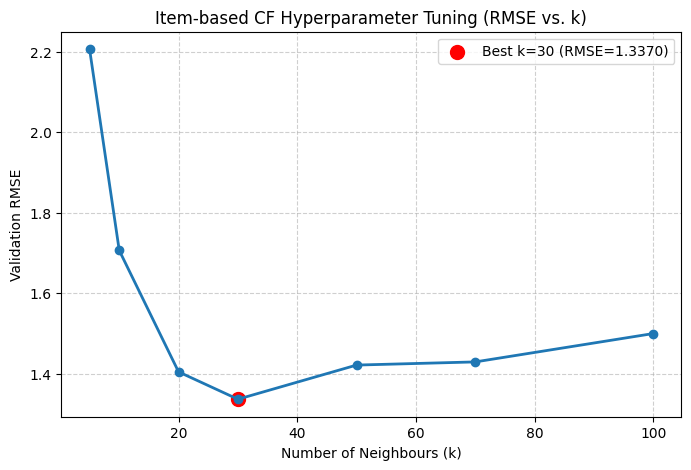

In [198]:
# Visualize ItemKNN hyperparameter tuning results

results_df = pd.DataFrame(item_knn_tuning['results'], columns=['k', 'RMSE'])

plt.figure(figsize=(8,5))
plt.plot(results_df['k'], results_df['RMSE'], marker='o', linestyle='-', linewidth=2)
plt.title("Item-based CF Hyperparameter Tuning (RMSE vs. k)")
plt.xlabel("Number of Neighbours (k)")
plt.ylabel("Validation RMSE")
plt.grid(True, linestyle='--', alpha=0.6)

# Highlight the best k
best_k = item_knn_tuning['best_k']
best_rmse = item_knn_tuning['best_rmse']
rmse_item_based = best_rmse
plt.scatter(best_k, best_rmse, color='red', s=100, label=f"Best k={best_k} (RMSE={best_rmse:.4f})")
plt.legend()
plt.show()

> Based on the results and as seen in the visualization, we take 20 to be the best number of neighbours.

## 1.4 Matrix Factorization model (MF)

### MF Model

In [199]:
class MFModel(nn.Module):
    def __init__(self, num_users, num_items, num_factors=32):
        super(MFModel, self).__init__()
        # User and item embeddings
        self.user_emb = nn.Embedding(num_users, num_factors)
        self.item_emb = nn.Embedding(num_items, num_factors)
        self._init_weights()

    def _init_weights(self):
        nn.init.normal_(self.user_emb.weight, std=0.01)
        nn.init.normal_(self.item_emb.weight, std=0.01)

    def forward(self, user_ids, item_ids):
        # Dot product between user and item embeddings
        u = self.user_emb(user_ids)
        i = self.item_emb(item_ids)
        pred = (u * i).sum(dim=1)
        return pred

In [200]:
class MFTrainer:
    def __init__(self, num_users, num_items, num_factors=32, lr=0.01, reg=1e-4, epochs=10, device="cpu", outputs_path="outputs"):
        self.device = device
        self.num_users = num_users
        self.num_items = num_items
        self.outputs_path = os.path.join(outputs_path, 'MF')
        os.makedirs(self.outputs_path, exist_ok=True)
        self.model_file = os.path.join(self.outputs_path, "mf_model.pt")

        self.model = MFModel(num_users, num_items, num_factors).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=reg)
        self.epochs = epochs
        self.loss_fn = nn.MSELoss()

        # Check if model file exists and load it
        self.trained = False
        if os.path.exists(self.model_file):
            try:
                self.model.load_state_dict(torch.load(self.model_file, map_location=device))
                self.trained = True
                print(f"Loaded pre-trained MF model from {self.model_file}")
            except:
                print("Failed to load MF model, will train from scratch.")

    def train(self, train_data, force_retrain=False):
        if self.trained and not force_retrain:
            print("MF model already trained, skipping training.")
            return

        users = torch.LongTensor(train_data['user_id'].values - 1).to(self.device)
        items = torch.LongTensor(train_data['item_id'].values - 1).to(self.device)
        ratings = torch.FloatTensor(train_data['rating'].values).to(self.device)

        dataset = torch.utils.data.TensorDataset(users, items, ratings)
        loader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True)

        print("Training MF...")
        for epoch in range(self.epochs):
            total_loss = 0
            for u, i, r in loader:
                pred = self.model(u, i)
                loss = self.loss_fn(pred, r)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()
            print(f"Epoch {epoch+1}/{self.epochs}, Loss={total_loss/len(loader):.4f}")

        # Save trained model
        torch.save(self.model.state_dict(), self.model_file)
        self.trained = True
        print(f"MF model saved to {self.model_file}")

    def predict(self, user_id, item_id):
        self.model.eval()
        user = torch.LongTensor([user_id - 1]).to(self.device)
        item = torch.LongTensor([item_id - 1]).to(self.device)
        with torch.no_grad():
            pred = self.model(user, item)
        return pred.item()

    def evaluate(self, data: pd.DataFrame) -> float:
        self.model.eval() 

        # Prepare data
        users = torch.LongTensor(data["user_id"].values - 1).to(self.device)
        items = torch.LongTensor(data["item_id"].values - 1).to(self.device)
        ratings = torch.FloatTensor(data["rating"].values).to(self.device)

        rmse = 0.0
        with torch.no_grad():
            preds = self.model(users, items)
            rmse = torch.sqrt(torch.mean((preds - ratings) ** 2)).item()

        return rmse

### MF Hyperparam Searching and Training

In [201]:
def hyperparameter_search_MF(train_data, val_data, num_users, num_items, device, OUTPUTS_PATH, force_retrain=False):
    """Perform grid search over MF hyperparameters."""

    mf_param_grid = {
        "num_factors": [16, 32, 64],
        "lr": [0.005, 0.01],
        "reg": [1e-4, 1e-3],
    }

    best_result = {"rmse": float("inf"), "params": None}

    print("\n=== MF Hyperparameter Search ===")
    for num_factors, lr, reg in itertools.product(
            mf_param_grid["num_factors"],
            mf_param_grid["lr"],
            mf_param_grid["reg"]):

        print(f"\nTraining MF with num_factors={num_factors}, lr={lr}, reg={reg}")
        mf_trainer = MFTrainer(
            num_users, num_items, num_factors=num_factors, lr=lr, reg=reg,
            epochs=5, device=device, outputs_path=OUTPUTS_PATH
        )
        mf_trainer.train(train_data, force_retrain=force_retrain)

        # ---- Evaluate on test set using RMSE ----
        rmse = mf_trainer.evaluate(val_data)

        print(f"Validation RMSE = {rmse:.4f}")

        if rmse < best_result["rmse"]:
            best_result["rmse"] = rmse
            best_result["params"] = (num_factors, lr, reg)

    print(f"\n✅ Best MF Config: factors={best_result['params'][0]}, "
          f"lr={best_result['params'][1]}, reg={best_result['params'][2]}, "
          f"RMSE={best_result['rmse']:.4f}")

    best_num_factors, best_lr, best_reg = best_result["params"]
    final_mf = MFTrainer(
        num_users, num_items, num_factors=best_num_factors, lr=best_lr, reg=best_reg,
        epochs=10, device=device, outputs_path=OUTPUTS_PATH
    )
    final_mf.train(train_data, force_retrain=force_retrain)

    print("MF Prediction Example:", final_mf.predict(1, 50))
    return final_mf, best_result['rmse']

In [202]:
# mf_model = hyperparameter_search_MF(train_data, val_data, num_users, num_items, device, OUTPUTS_PATH, True)  # for retraining
mf_model, rmse_mf = hyperparameter_search_MF(train_data, val_data, num_users, num_items, device, OUTPUTS_PATH)


=== MF Hyperparameter Search ===

Training MF with num_factors=16, lr=0.005, reg=0.0001
Loaded pre-trained MF model from /Users/kantatanahashi/Documents/master_cs/recommender_systems/Project-RecSys/data/MF/mf_model.pt
MF model already trained, skipping training.
Validation RMSE = 0.9579

Training MF with num_factors=16, lr=0.005, reg=0.001
Loaded pre-trained MF model from /Users/kantatanahashi/Documents/master_cs/recommender_systems/Project-RecSys/data/MF/mf_model.pt
MF model already trained, skipping training.
Validation RMSE = 0.9579

Training MF with num_factors=16, lr=0.01, reg=0.0001
Loaded pre-trained MF model from /Users/kantatanahashi/Documents/master_cs/recommender_systems/Project-RecSys/data/MF/mf_model.pt
MF model already trained, skipping training.
Validation RMSE = 0.9579

Training MF with num_factors=16, lr=0.01, reg=0.001
Loaded pre-trained MF model from /Users/kantatanahashi/Documents/master_cs/recommender_systems/Project-RecSys/data/MF/mf_model.pt
MF model already tra

In [203]:
print(f"Minimum Validation RMSE from MF: {rmse_mf:.4f}")

Minimum Validation RMSE from MF: 0.9579


### Recommend Top K items based on matrix factorization

In [234]:
import torch
import numpy as np
import pandas as pd


def recommend_topk_mf(
    mf_trainer: MFTrainer, train_data: pd.DataFrame, target_user: int, k: int
):
    """
    Generates Top-K recommendations for a target user using the trained MF model.

    This function predicts scores for all items the user has not yet rated
    in a single batch for efficiency.

    Args:
        mf_trainer (MFTrainer): The trained MFTrainer object from your code.
        train_data (pd.DataFrame): Training data used to find already-rated items.
        target_user (int): The target user ID (assumed to be 1-indexed).
        k (int): The number of items to recommend.

    Returns:
        list: A list of k item IDs (1-indexed), sorted by predicted score.
    """
    mf_trainer.model.eval()
    user_rated_items = set(train_data[train_data["user_id"] == target_user]["item_id"])
    all_items = set(range(1, mf_trainer.num_items + 1))
    candidate_items = all_items - user_rated_items
    candidate_items_list = sorted(list(candidate_items))

    # 3. Prepare tensors for batch prediction
    device = mf_trainer.device

    # Create a tensor for the user ID (0-indexed), repeated for all candidate items
    users_tensor = (
        torch.LongTensor([target_user - 1]).expand(len(candidate_items_list)).to(device)
    )

    # Create a tensor for all 0-indexed candidate item IDs
    items_tensor = torch.LongTensor(np.array(candidate_items_list) - 1).to(device)

    # 4. Get all predictions in one batch
    with torch.no_grad():
        predictions = mf_trainer.model(users_tensor, items_tensor)


    scores = predictions.cpu().numpy()
    item_scores = list(zip(candidate_items_list, scores))

    item_scores.sort(key=lambda x: x[1], reverse=True)

    top_k_recommendations = [item_id for item_id, score in item_scores[:k]]

    return top_k_recommendations

In [235]:
target_user = 1
k = 10

recommendations = recommend_topk_mf(
    mf_trainer=mf_model, train_data=train_data, target_user=target_user, k=k
)

print(f"Top-{k} recommendations based on matrix factorizationfor user {target_user}:")
print(recommendations)

Top-10 recommendations based on matrix factorizationfor user 1:
[483, 318, 134, 408, 12, 515, 174, 519, 302, 1142]


## 1.5 Bayesian Personalized Ranking method (BPR)

BPR is a pairwise ranking optimization method for personalized recommendation. The main idea of BPR is to optimize the ranking of items for each user by maximizing the difference in predicted scores between items that a user has interacted with (positive items) and items that they have not interacted with (negative items).

Here, MF is served as the underlying model for BPR. Objective function of BPR (MF-based) is defined as follows:

$$\sum_{(u, i, j) \in D_S} \ln \sigma(\hat{x}_{ui} - \hat{x}_{uj}) - \lambda_{\Theta} ||\Theta||^2$$

where $D_S$ is the set of all user-item pairs such that user $u$ has interacted with item $i$ (positive item) but not with item $j$ (negative item), $\sigma$ is the sigmoid function, $\hat{x}_{ui}$ and $\hat{x}_{uj}$ are the predicted scores for user $u$ on items $i$ and $j$, respectively, $\Theta$ represents the model parameters (user and item latent factors), and $\lambda_{\Theta}$ is the regularization parameter to prevent overfitting.

### BPR Model

In [204]:
class BPRModel(nn.Module):
    def __init__(self, num_users, num_items, num_factors=32):
        super(BPRModel, self).__init__()
        # User and item embeddings without bias
        self.user_emb = nn.Embedding(num_users, num_factors)
        self.item_emb = nn.Embedding(num_items, num_factors)
        self._init_weights()

    def _init_weights(self):
        nn.init.normal_(self.user_emb.weight, std=0.1)
        nn.init.normal_(self.item_emb.weight, std=0.1)

    def forward(self, user, item_i, item_j):
        # Compute difference between positive and negative item scores
        u = self.user_emb(user)
        i = self.item_emb(item_i)
        j = self.item_emb(item_j)
        x_ui = (u * i).sum(dim=1)
        x_uj = (u * j).sum(dim=1)
        return x_ui - x_uj

    def predict(self, user, item):
        # Compute preference score for a single item
        u = self.user_emb(user)
        i = self.item_emb(item)
        return (u * i).sum(dim=1)

In [205]:
class BPRTrainer:
    def __init__(self, num_users, num_items, num_factors=32, lr=0.01, reg=1e-4, epochs=10,
                 device="cpu", outputs_path="outputs", batch_size=1024):
        self.device = device
        self.outputs_path = os.path.join(outputs_path, 'BPR')
        os.makedirs(self.outputs_path, exist_ok=True)
        self.model_file = os.path.join(self.outputs_path, "bpr_model.pt")
        self.batch_size = batch_size

        self.model = BPRModel(num_users, num_items, num_factors).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=reg)
        self.epochs = epochs

        self.trained = False
        if os.path.exists(self.model_file):
            try:
                self.model.load_state_dict(torch.load(self.model_file, map_location=device))
                self.trained = True
                print(f"Loaded pre-trained BPR model from {self.model_file}")
            except:
                print("Failed to load BPR model, will train from scratch.")

    def _build_user_pos(self, train_data):
        user_pos = defaultdict(set)
        for _, row in train_data.iterrows():
            user_pos[int(row['user_id']) - 1].add(int(row['item_id']) - 1)
        return user_pos

    def train(self, train_data, force_retrain=False):
        if self.trained and not force_retrain:
            print("BPR model already trained, skipping training.")
            return

        user_pos = self._build_user_pos(train_data)
        num_items = self.model.item_emb.num_embeddings
        all_items = np.arange(num_items)

        print("Training BPR with mini-batch...")
        for epoch in range(self.epochs):
            batch_u, batch_i, batch_j = [], [], []
            total_loss = 0
            for u in user_pos:
                pos_items = list(user_pos[u])
                if len(pos_items) == 0:
                    continue
                for i in pos_items:
                    # sample negative
                    j = np.random.choice(np.setdiff1d(all_items, pos_items))
                    batch_u.append(u)
                    batch_i.append(i)
                    batch_j.append(j)
                    # train in batch
                    if len(batch_u) >= self.batch_size:
                        loss = self._train_batch(batch_u, batch_i, batch_j)
                        total_loss += loss
                        batch_u, batch_i, batch_j = [], [], []
            # train remaining
            if batch_u:
                loss = self._train_batch(batch_u, batch_i, batch_j)
                total_loss += loss

            print(f"Epoch {epoch+1}/{self.epochs}, Avg Loss={total_loss/len(user_pos):.4f}")

        torch.save(self.model.state_dict(), self.model_file)
        self.trained = True
        print(f"BPR model saved to {self.model_file}")

    def _train_batch(self, batch_u, batch_i, batch_j):
        batch_u = torch.LongTensor(batch_u).to(self.device)
        batch_i = torch.LongTensor(batch_i).to(self.device)
        batch_j = torch.LongTensor(batch_j).to(self.device)

        x_uij = self.model(batch_u, batch_i, batch_j)
        loss = -torch.log(torch.sigmoid(x_uij)).mean()

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def recommend(self, user_id, train_data=None, top_k=10):
        self.model.eval()
        u = torch.LongTensor([user_id - 1]).to(self.device)
        scores = self.model.predict(u, torch.arange(self.model.item_emb.num_embeddings).to(self.device)).cpu().detach().numpy()
        if train_data is not None:
            interacted = set(train_data[train_data['user_id'] == user_id]['item_id'])
        else:
            interacted = set()
        candidates = [(i+1, s) for i, s in enumerate(scores) if (i+1) not in interacted]
        candidates.sort(key=lambda x: x[1], reverse=True)
        return candidates[:top_k]

### BPR Hyperparam Searching and Training

> Since BPR is a ranking task, nDCG/MRR/Precision/Recall can be used as target. However, `loss` is used here for simplicity.

In [206]:
def hyperparameter_search_BPR(train_data, num_users, num_items, device, OUTPUTS_PATH, force_retrain=False):
    """Perform grid search over BPR hyperparameters."""

    bpr_param_grid = {
        "num_factors": [16, 32, 64],
        "lr": [0.005, 0.01],
        "reg": [1e-4, 1e-3],
    }

    best_result = {"loss": float("inf"), "params": None}

    print("\n=== BPR Hyperparameter Search ===")
    for num_factors, lr, reg in itertools.product(
            bpr_param_grid["num_factors"],
            bpr_param_grid["lr"],
            bpr_param_grid["reg"]):

        print(f"\nTraining BPR with num_factors={num_factors}, lr={lr}, reg={reg}")
        bpr_trainer = BPRTrainer(
            num_users, num_items, num_factors=num_factors, lr=lr, reg=reg,
            epochs=5, device=device, outputs_path=OUTPUTS_PATH
        )
        bpr_trainer.train(train_data, force_retrain=force_retrain)

        # ---- Compute average training loss as proxy metric ----
        user_pos = bpr_trainer._build_user_pos(train_data)
        total_loss = 0
        num_samples = 0

        for u in list(user_pos.keys())[:200]:  # sample subset for speed
            pos_items = list(user_pos[u])
            if len(pos_items) == 0:
                continue
            j = np.random.randint(0, num_items)
            u_tensor = torch.LongTensor([u]).to(device)
            i_tensor = torch.LongTensor([pos_items[0]]).to(device)
            j_tensor = torch.LongTensor([j]).to(device)

            with torch.no_grad():
                x_uij = bpr_trainer.model(u_tensor, i_tensor, j_tensor)
                loss = -torch.log(torch.sigmoid(x_uij)).mean().item()

            total_loss += loss
            num_samples += 1

        avg_loss = total_loss / num_samples
        print(f"Validation Avg Loss = {avg_loss:.4f}")

        if avg_loss < best_result["loss"]:
            best_result["loss"] = avg_loss
            best_result["params"] = (num_factors, lr, reg)

    print(f"\n✅ Best BPR Config: factors={best_result['params'][0]}, "
          f"lr={best_result['params'][1]}, reg={best_result['params'][2]}, "
          f"Loss={best_result['loss']:.4f}")

    # ---- Train final model with best hyperparameters ----
    best_num_factors, best_lr, best_reg = best_result["params"]
    final_bpr = BPRTrainer(
        num_users, num_items, num_factors=best_num_factors, lr=best_lr, reg=best_reg,
        epochs=10, device=device, outputs_path=OUTPUTS_PATH
    )
    final_bpr.train(train_data, force_retrain=force_retrain)

    print("BPR Top-5 Recommendations:", final_bpr.recommend(1, train_data=train_data, top_k=5))
    return final_bpr

In [207]:
# bpr_model = hyperparameter_search_BPR(train_data, num_users, num_items, device, OUTPUTS_PATH, True)  # force retraining
bpr_model = hyperparameter_search_BPR(train_data, num_users, num_items, device, OUTPUTS_PATH)


=== BPR Hyperparameter Search ===

Training BPR with num_factors=16, lr=0.005, reg=0.0001
Failed to load BPR model, will train from scratch.
Training BPR with mini-batch...
Epoch 1/5, Avg Loss=0.0463
Epoch 2/5, Avg Loss=0.0461
Epoch 3/5, Avg Loss=0.0444
Epoch 4/5, Avg Loss=0.0382
Epoch 5/5, Avg Loss=0.0317
BPR model saved to /Users/kantatanahashi/Documents/master_cs/recommender_systems/Project-RecSys/data/BPR/bpr_model.pt
Validation Avg Loss = 0.3562

Training BPR with num_factors=16, lr=0.005, reg=0.001
Loaded pre-trained BPR model from /Users/kantatanahashi/Documents/master_cs/recommender_systems/Project-RecSys/data/BPR/bpr_model.pt
BPR model already trained, skipping training.
Validation Avg Loss = 0.3443

Training BPR with num_factors=16, lr=0.01, reg=0.0001
Loaded pre-trained BPR model from /Users/kantatanahashi/Documents/master_cs/recommender_systems/Project-RecSys/data/BPR/bpr_model.pt
BPR model already trained, skipping training.
Validation Avg Loss = 0.3501

Training BPR with

In [233]:
target_user = 1
k = 10

recommendations = bpr_model.recommend(
    target_user, train_data, k
)

print(f"Top-{k} recommendations based on Bayesian Personalized Ranking for user {target_user}:")
print(recommendations)

Top-10 recommendations based on Bayesian Personalized Ranking for user 1:
[(1, np.float32(2.6762147)), (258, np.float32(2.5547805)), (100, np.float32(2.4790208)), (286, np.float32(2.3197646)), (7, np.float32(2.3117995)), (174, np.float32(2.2664165)), (121, np.float32(2.250526)), (117, np.float32(2.1995082)), (56, np.float32(2.1526427)), (288, np.float32(2.0838485))]


## 1.6 Hybrid recommender

### Generate component predictions

Each base model gives a predicted rating:

[
score_{C_j}(u,i)
]

for a user u and item i.

The hybrid model learns how to **weight these base model predictions** to produce a final score:

[
score(u,i) = \sum_{j=1}^k \alpha_j , score_{C_j}(u,i)
]

where the (\alpha_j) coefficients show how much each component contributes.


In [208]:
def generate_component_predictions(val_data, train_data,
                                   item_similarity_matrix, user_similarity_matrix,
                                   mf_model, bpr_model,
                                   k_item=20, k_user=70,
                                   device='cpu', verbose=False):
    """
    Generate predictions from multiple recommender components for each (user, item) pair.

    Handles both 0-indexed and 1-indexed matrices automatically.
    Returns DataFrame with columns:
    [user_id, item_id, true_rating, cb, userknn, itemknn, mf, bpr]
    """

    preds = []
    skipped = 0

    # Detect index offset automatically (0-indexed or 1-indexed)
    user_min = user_similarity_matrix.index.min()
    item_min = item_similarity_matrix.index.min()

    user_offset = 1 if user_min == 0 else 0
    item_offset = 1 if item_min == 0 else 0

    global_mean_rating = train_data["rating"].mean()

    if pd.isna(global_mean_rating):
        print("!!! CRITICAL ERROR: global_mean_rating is NaN !!!")
        print("This means your train_data['rating'] column might be all NaNs.")
        print("Dropping NaNs from training data for mean calculation...")
        # Try a fallback mean calculation
        global_mean_rating = train_data["rating"].dropna().mean()
        if pd.isna(global_mean_rating):
            raise ValueError(
                "CRITICAL: Still cannot calculate global_mean_rating. Check train_data."
            )

    if verbose:
        print(f"Detected user matrix offset: {user_offset}, item matrix offset: {item_offset}")

    for idx, row in val_data.iterrows():
        user_id, item_id, true_rating = int(row['user_id']), int(row['item_id']), row['rating']

        try:
            # --- Content-based prediction (using full embedding, average aggregation) ---
            cb_pred = get_user_item_prediction_content_based(train_data, user_id, item_id, 'full', 'weighted_avg')

            # --- User-based CF prediction ---
            adj_user_id = user_id - user_offset
            if adj_user_id not in user_similarity_matrix.index:
                raise KeyError(f"User {adj_user_id} not in similarity matrix")
            ub_pred = predict_rating_user_based(
                train_data,
                user_similarity_matrix,
                user_id,
                item_id,
                global_mean_rating, k=k_user,
            )

            # --- Item-based CF prediction ---
            adj_item_id = item_id - item_offset
            if adj_item_id not in item_similarity_matrix.index:
                raise KeyError(f"Item {adj_item_id} not in similarity matrix")
            ib_pred = predict_rating_item_based(train_data, item_similarity_matrix, user_id, item_id, k=k_item)

            # --- Matrix Factorization prediction ---
            mf_pred = mf_model.predict(user_id, item_id)

            # --- BPR prediction ---
            with torch.no_grad():
                bpr_model.model.to(device)
                bpr_pred = bpr_model.model.predict(
                    torch.LongTensor([user_id - 1]).to(device),
                    torch.LongTensor([item_id - 1]).to(device)
                ).item()

            preds.append([user_id, item_id, true_rating, cb_pred, ub_pred, ib_pred, mf_pred, bpr_pred])

        except Exception as e:
            skipped += 1
            if verbose:
                print(f"⚠️ Skipped user {user_id}, item {item_id}: {e}")
            continue

    df_preds = pd.DataFrame(preds, columns=['user_id', 'item_id', 'true_rating', 'cb', 'userknn', 'itemknn', 'mf', 'bpr'])
    print(f"✅ Completed hybrid prediction data generation. Skipped {skipped} problematic pairs.")
    print(f"Returned shape: {df_preds.shape}")
    return df_preds

### Train the hybrid regression model

In [214]:
from sklearn.linear_model import LinearRegression

# Generate predictions for validation set
hybrid_train = generate_component_predictions(
    val_data, train_data,
    item_similarity_matrix, user_similarity_matrix,
    mf_model, bpr_model,
    k_item=20, k_user=70,
    verbose=True
)

X = hybrid_train[['cb','userknn','itemknn','mf','bpr']]
y = hybrid_train['true_rating']

# Train regression model
hybrid_reg = LinearRegression(fit_intercept=True)

hybrid_reg.fit(X, y)

# Display learned coefficients
coefficients = pd.DataFrame({
    'Component': X.columns,
    'Alpha (Weight)': hybrid_reg.coef_
})
display(coefficients)
print(f"Intercept (bias): {hybrid_reg.intercept_:.4f}")


Detected user matrix offset: 0, item matrix offset: 0
⚠️ Skipped user 782, item 1666: 'Item 1666 not in similarity matrix'
⚠️ Skipped user 655, item 1636: 'Item 1636 not in similarity matrix'
⚠️ Skipped user 675, item 1653: 'Item 1653 not in similarity matrix'
⚠️ Skipped user 405, item 1576: 'Item 1576 not in similarity matrix'
⚠️ Skipped user 405, item 1571: 'Item 1571 not in similarity matrix'
⚠️ Skipped user 782, item 1669: 'Item 1669 not in similarity matrix'
⚠️ Skipped user 425, item 1595: 'Item 1595 not in similarity matrix'
⚠️ Skipped user 655, item 1532: 'Item 1532 not in similarity matrix'
⚠️ Skipped user 405, item 1384: 'Item 1384 not in similarity matrix'
⚠️ Skipped user 676, item 1654: 'Item 1654 not in similarity matrix'
⚠️ Skipped user 474, item 1123: 'Item 1123 not in similarity matrix'
⚠️ Skipped user 655, item 913: 'Item 913 not in similarity matrix'
⚠️ Skipped user 405, item 1334: 'Item 1334 not in similarity matrix'
⚠️ Skipped user 279, item 1494: 'Item 1494 not in s

,Component,Alpha (Weight)
0,cb,0.003549
1,userknn,0.423273
2,itemknn,-0.033547
3,mf,0.526662
4,bpr,-0.010389


Intercept (bias): -0.1814


In [215]:
print(hybrid_train.isna().sum())

user_id        0
item_id        0
true_rating    0
cb             0
userknn        0
itemknn        0
mf             0
bpr            0
dtype: int64


### Check ranges and summary stats

In [216]:
# Look at the min, max, mean, std for each component
hybrid_train[['cb','userknn','itemknn','mf','bpr']].describe().T

,count,mean,std,min,25%,50%,75%,max
cb,15961.0,142.789984,3.568201,117.903825,140.814418,143.147208,145.144278,162.964259
userknn,15961.0,3.576849,0.656311,1.000000,3.185747,3.625901,4.032367,5.000000
itemknn,15961.0,3.499221,0.551149,1.000000,3.151093,3.547954,3.895980,4.950171
mf,15961.0,3.470011,0.745094,0.175989,3.013984,3.521754,3.994270,6.332113
bpr,15961.0,1.087750,0.847243,-1.405951,0.479870,1.099696,1.693091,3.932464


### Train the regression after scaling

In [217]:
from sklearn.preprocessing import StandardScaler

# Select only numeric prediction columns
X = hybrid_train[['cb','userknn','itemknn','mf','bpr']]

# Fit the scaler on training data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train regression on scaled features
hybrid_reg_scaled = LinearRegression()
hybrid_reg_scaled.fit(X_scaled, hybrid_train['true_rating'])

# Show new coefficients
coefficients_scaled = pd.DataFrame({
    'Component': X.columns,
    'Alpha (Weight)': hybrid_reg_scaled.coef_
})
display(coefficients_scaled)
print(f"Intercept (bias): {hybrid_reg_scaled.intercept_:.4f}")

,Component,Alpha (Weight)
0,cb,0.012664
1,userknn,0.277790
2,itemknn,-0.018489
3,mf,0.392401
4,bpr,-0.008801


Intercept (bias): 3.5382


Before scaling the predictors have different magnitudes. The regression absorbs those differences into both coefficients and intercept so the small negative intercept just compensates for overly high CB predictions. After scaling, all predictors are centered (mean=0) and standardized (std=1) so the intercept becomes the mean of the target, i.e. the average movie rating.

### Generate Top-K recommendations for a given user using the trained hybrid regression model.

TODO: change 20 to best_k

In [218]:
def recommend_topk_hybrid(user_id, hybrid_model, train_data, item_similarity_matrix, user_similarity_matrix,
                          mf_model, bpr_model, scaler, k_item=20, k_user=50, top_k=10, device='cpu'):
    """
    Generate Top-K recommendations for a given user using the trained hybrid regression model.

    Args:
        user_id (int): Target user.
        hybrid_model: Trained LinearRegression model (hybrid_reg_scaled).
        train_data (pd.DataFrame): Training ratings.
        item_similarity_matrix (pd.DataFrame): Precomputed item-item similarities.
        user_similarity_matrix (pd.DataFrame): Precomputed user-user similarities.
        mf_model: Trained MF model.
        bpr_model: Trained BPR model.
        scaler: StandardScaler fitted on hybrid training data.
        k_item (int): Number of neighbors for ItemKNN.
        k_user (int): Number of neighbors for UserKNN.
        top_k (int): Number of items to recommend.
        device (str): 'cpu' or 'cuda'.

    Returns:
        list of (item_id, hybrid_pred_score)
    """
    # Get items the user already rated
    user_rated_items = set(train_data[train_data['user_id'] == user_id]['item_id'])
    all_items = set(train_data['item_id'].unique())
    candidate_items = all_items - user_rated_items

    predictions = []
    for item_id in candidate_items:
        try:
            # --- Get component predictions ---
            cb_pred = get_user_item_prediction_content_based(train_data, user_id, item_id, 'full', 'weighted_avg')
            ub_pred = predict_rating_user_based(train_data, user_similarity_matrix, user_id, item_id, k=k_user)
            ib_pred = predict_rating_item_based(train_data, item_similarity_matrix, user_id, item_id, k=k_item)
            mf_pred = mf_model.predict(user_id, item_id)
            with torch.no_grad():
                bpr_model.model.to(device)
                bpr_pred = bpr_model.model.predict(
                    torch.LongTensor([user_id - 1]).to(device),
                    torch.LongTensor([item_id - 1]).to(device)
                ).item()

            # Prepare feature vector for hybrid model
            features = np.array([[cb_pred, ub_pred, ib_pred, mf_pred, bpr_pred]])
            features_scaled = scaler.transform(features)
            hybrid_pred = hybrid_model.predict(features_scaled)[0]

            predictions.append((item_id, hybrid_pred))

        except Exception as e:
            # Skip if prediction not possible
            continue

    # Sort by predicted rating descending
    recommendations = sorted(predictions, key=lambda x: x[1], reverse=True)[:top_k]
    return recommendations


### Make hybrid predictions on test set (maybe move this to Task 2)


In [219]:
def evaluate_hybrid_models(
    test_data,
    train_data,
    item_similarity_matrix,
    user_similarity_matrix,
    mf_model,
    hybrid_reg_scaled,
    bpr_model,
    k_item,
    k_user,
    device="cpu",
):
    # Generate component predictions on test data
    hybrid_test = generate_component_predictions(
        test_data,
        train_data,
        item_similarity_matrix,
        user_similarity_matrix,
        mf_model,
        bpr_model,
        k_item=k_item,
        k_user=k_user,
        device=device,
        verbose=False,
    )

    # Predict using learned hybrid regression
    X_test = hybrid_test[["cb", "userknn", "itemknn", "mf", "bpr"]]
    y_test = hybrid_test["true_rating"]
    y_pred = hybrid_reg.predict(X_test)

    # Evaluate
    test_rmse = RMSE(y_test, y_pred)
    print(f"✅ Hybrid Test RMSE = {test_rmse:.4f}")

    X_test_scaled = scaler.transform(hybrid_test[["cb", "userknn", "itemknn", "mf", "bpr"]])
    y_pred_scaled = hybrid_reg_scaled.predict(X_test_scaled)
    test_rmse_scaled = RMSE(hybrid_test["true_rating"], y_pred_scaled)
    print(f"✅ Scaled Hybrid Test RMSE = {test_rmse_scaled:.4f}")

    return test_rmse_scaled

rmse_hybrid = evaluate_hybrid_models(
    test_data,
    train_data,
    item_similarity_matrix,
    user_similarity_matrix,
    mf_model,
    hybrid_reg_scaled,
    bpr_model,
    k_item=20,
    k_user=70,
    device=device,
)

✅ Completed hybrid prediction data generation. Skipped 40 problematic pairs.
Returned shape: (19960, 8)
✅ Hybrid Test RMSE = 0.9410
✅ Scaled Hybrid Test RMSE = 0.9410


> Although scaling did not change RMSE (since linear regression predictions are invariant to affine scaling of inputs), it standardized the component feature space. This gives interpretable weights (comparable across models) and ensures numerical stability. BPR is almost non significant because it is for ranking, not rating prediction.

### Visualize coefficient importance

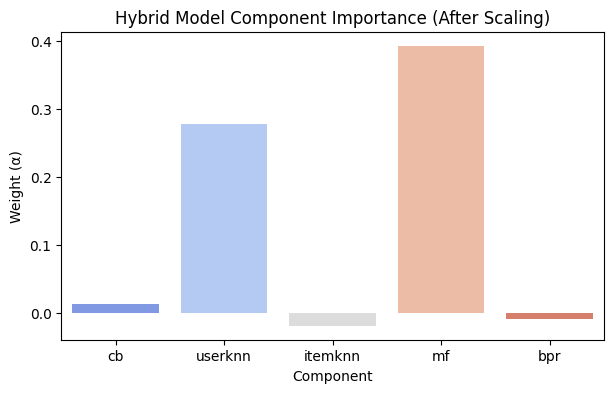

In [220]:
plt.figure(figsize=(7,4))
sns.barplot(data=coefficients_scaled, x='Component', y='Alpha (Weight)', palette='coolwarm')
plt.title('Hybrid Model Component Importance (After Scaling)')
plt.ylabel('Weight (α)')
plt.show()


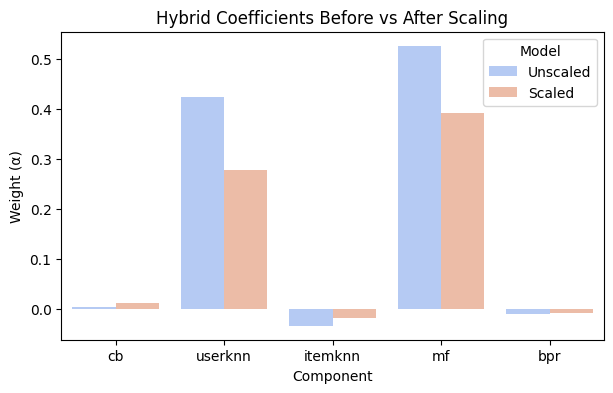

In [221]:
coeff_compare = pd.DataFrame({
    'Component': X.columns,
    'Unscaled': hybrid_reg.coef_,
    'Scaled': hybrid_reg_scaled.coef_
}).melt(id_vars='Component', var_name='Model', value_name='Weight (α)')

plt.figure(figsize=(7,4))
sns.barplot(data=coeff_compare, x='Component', y='Weight (α)', hue='Model', palette='coolwarm')
plt.title('Hybrid Coefficients Before vs After Scaling')
plt.show()


# Task 2) Experiments for both rating prediction and ranking tasks, and conducting offline evaluation

In [225]:
def Precision(ground_truth, rec_list):
    # Implement a function that computes Precision across ground truth data and recommendation list generated for each user.
    # Note that ground_truth and rec_list contain the list of items for all users, e.g., 2-dimensional arrays.

    result = 0.0


    ############# Your code here ############
    # Precision measures how many of the positive samples are actually positive
    # so how many of the recommended items are actually relevant

    precisions = []

    for gt, rec in zip(ground_truth, rec_list):
        if not rec:
            continue
        hits = len(set(gt) & set(rec))
        precision = hits / len(rec)
        precisions.append(precision)

    result = np.mean(precisions)
    #########################################

    return result

def Recall(ground_truth, rec_list):
    # Implement a function that computes Recall across ground truth data and recommendation list generated for each user.
    # Note that ground_truth and rec_list contain the list of items for all users, e.g., 2-dimensional arrays.

    result = 0.0

    ############# Your code here ############
    # recall is out of all relevant items, how many did it positively predict
    recalls = []

    for gt, rec in zip(ground_truth, rec_list):
        if not rec or not gt:
            continue
        hits = len(set(gt) & set(rec))
        recall = hits / len(gt)
        recalls.append(recall)

    result = np.mean(recalls)

    #########################################

    return result

def NDCG(ground_truth, rec_list):
    # Implement a function that computes NDCG across ground truth data and recommendation list generated for each user.
    # Note that ground_truth and rec_list contain the list of items for all users, e.g., 2-dimensional arrays.

    result = 0.0

    ############# Your code here ############
    ndcgs = []
    for gt_items, rec_items in zip(ground_truth, rec_list):
        dcg = 0.0

        # Calculate DCG
        for i, item in enumerate(rec_items):
            if item in gt_items:
                dcg += 1.0 / np.log2(i + 1)

        # Calculate IDCG
        idcg = 0.0
        for i in range(min(len(rec_items), len(gt_items))):
            idcg += 1.0 / np.log2(i + 1)

        # Calculate NDCG
        if idcg == 0:
            ndcgs.append(0.0)
        else:
            ndcgs.append(dcg / idcg)

    return np.mean(ndcgs)
    #########################################

## 2.1 Rating Prediction Task Evaluation

In [ ]:
# We computed this when we optimized hyperparameters earlier but here we go again
# RMSE of content-based, user-based, item-based, and matrix factorization model as well as the hybrid model


if rmse_content_based and rmse_user_based and rmse_item_based and rmse_mf and rmse_hybrid:
    print("Skipping evaluation, already computed.")
    print(f"Content-based RMSE: {rmse_content_based}")
    print(f"User-based RMSE: {rmse_user_based}")
    print(f"Item-based RMSE: {rmse_item_based}")
    print(f"Matrix Factorization RMSE: {rmse_mf}")  
    print(f"Hybrid RMSE: {rmse_hybrid}")

else:
    print("Running Content rating based evaluations on test data...")
    rmse_content_based = evaluate_rating_prediction_content_based(
                train_data,
                test_data,
                "full",
                "weighted_avg")

    print("Running user based rating evaluations on test data...")
    rmse_user_based = evaluate_rating_prediction_user_based(train_data, test_data, user_similarity_matrix, 70)

    print("Running item based rating evaluations on test data...")
    rmse_item_based = evaluate_rating_prediction_item_based(train_data, test_data, item_similarity_matrix, 20)

    print("Running matrix factorization rating evaluations on test data...")
    rmse_mf = mf_model.evaluate(test_data)

    print("Running hybrid rating evaluations on test data...")
    rmse_hybrid = evaluate_hybrid_models(
        test_data,
        train_data,
        item_similarity_matrix,
        user_similarity_matrix,
        mf_model,
        hybrid_reg_scaled,
        bpr_model,
        k_item=20,
        k_user=50,
        device=device,
    )

    print(type(rmse_content_based), rmse_content_based)
    print(type(rmse_user_based), rmse_user_based)
    print(type(rmse_item_based), rmse_item_based)
    print(type(rmse_mf), rmse_mf)
    print(type(rmse_hybrid), rmse_hybrid)

    # --- Final Comparison ---
    print("\n--- Model RMSE Comparison ---")
    results = {
        "Content-Based": rmse_content_based,
        "User-Based KNN": rmse_user_based,
        "Item-Based KNN": rmse_item_based,
        "Matrix Factorization": rmse_mf,
        "Hybrid (Scaled)": rmse_hybrid,
    }
    results_df = pd.DataFrame(list(results.items()), columns=["Model", "RMSE"])
    results_df = results_df.sort_values("RMSE").set_index("Model")
    display(results_df)

Skipping evaluation, already computed.
Content-based RMSE: 1.470036609267693
User-based RMSE: 0.9778749272232189
Item-based RMSE: 1.3370069905714375
Matrix Factorization RMSE: 0.9578588008880615
Hybrid RMSE: 0.9409514072294074


## 2.2 Ranking Prediction Task Evaluation

In [ ]:
def evaluate_all_models_ranking(
    train_data: pd.DataFrame,
    test_data: pd.DataFrame,
    user_similarity_matrix: pd.DataFrame,
    item_similarity_matrix: pd.DataFrame,
    mf_model,  
    bpr_model,
    k: int = 10,
) -> pd.DataFrame:
    """
    Evaluates all five models against the test data.
    Model objects are passed as direct parameters.
    Hyperparameters (k_user, k_item, etc.) are hardcoded inside.
    """

    test_users = test_data["user_id"].unique()

    # Data structures to hold results
    all_ground_truths = []

    # Define the models we are testing
    model_names = [
        "Content-Based",
        "User-Based KNN",
        "Item-Based KNN",
        "Matrix Factorization",
        "BPR Model",
    ]

    all_recommendations = {model_name: [] for model_name in model_names}

    for user_id in tqdm(test_users, desc="Evaluating all models via ranking task"):

        # Get all the items that the user has rated 4.0 or higher in the test set
        gt = list(test_data[(test_data['user_id'] == user_id) & (test_data['rating'] >= 4.0)]['item_id'])

        if not gt:
            continue

        all_ground_truths.append(gt)

        # Get recommendations from each one of the model

        # --- Content-Based ---
        recs_cb = recommend_topk_content_based(
            train_data=train_data,
            target_user=user_id,
            k=k,
            content_type="full",  
            aggregation_method="weighted_avg", 
        )

        recs_cb_ids = [item_id for item_id, score in recs_cb]

        # print(f"User {user_id} Content-Based Recs: {recs_cb[:5]}")
        all_recommendations["Content-Based"].append(recs_cb_ids)

        # --- User-Based KNN ---
        recs_ub = recommend_topk_user_based(
            train_data=train_data,
            target_user=user_id,
            k=k,
            user_similarity_matrix=user_similarity_matrix,
            k_user=50,  
        )

        recs_ub_ids = [item_id for item_id, score in recs_ub]

        # print(f"User {user_id} User-Based KNN Recs: {recs_ub[:5]}")
        all_recommendations["User-Based KNN"].append(recs_ub_ids)

        # --- Item-Based KNN ---
        recs_ib = recommend_topk_item_based(
            train_data=train_data,
            target_user=user_id,
            k=k,
            item_similarity_matrix=item_similarity_matrix,
            k_item=20,  
        )

        recs_ib_ids = [item_id for item_id, score in recs_ib]
        # print(f"User {user_id} Item-Based KNN Recs: {recs_ib[:5]}")
        all_recommendations["Item-Based KNN"].append(recs_ib_ids)

        # --- Matrix Factorization ---
        recs_mf = recommend_topk_mf(
            mf_trainer=mf_model, train_data=train_data, target_user=user_id, k=k
        )
        # print(f"User {user_id} Matrix Factorization Recs: {recs_mf[:5]}")
        all_recommendations["Matrix Factorization"].append(recs_mf)

        # --- BPR Model ---
        recs_bpr = bpr_model.recommend(target_user, train_data, k)
        # print(f"User {user_id} BPR Model Recs: {recs_bpr[:5]}")

        recs_bpr_ids = [item_id for item_id, score in recs_bpr]
        all_recommendations["BPR Model"].append(recs_bpr_ids)

    print("\nCalculating final metrics...")

    final_results = {}
    for model_name, rec_lists in all_recommendations.items():
        if not rec_lists:
            print(f"Warning: No recommendations generated for {model_name}")
            continue

        prec = Precision(all_ground_truths, rec_lists)
        rec = Recall(all_ground_truths, rec_lists)
        ndcg = NDCG(all_ground_truths, rec_lists)

        final_results[model_name] = {
            "Precision@K": prec,
            "Recall@K": rec,
            "NDCG@K": ndcg,
        }

    results_df = pd.DataFrame.from_dict(final_results, orient="index")
    results_df = results_df.sort_values("NDCG@K", ascending=False)

    return results_df

In [256]:
all_model_results = evaluate_all_models_ranking(
    train_data,
    test_data,
    user_similarity_matrix=user_similarity_matrix,
    item_similarity_matrix=item_similarity_matrix,
    mf_model=mf_model,
    bpr_model=bpr_model,
    k=10,
)

# Display the final comparison table
print("\n--- Final Model Comparison (Ranking Function) ---")
display(all_model_results)

Evaluating all models via ranking task:   0%|          | 0/459 [00:00<?, ?it/s]


ValueError: too many values to unpack (expected 2)

# Task 3) Implement baselines for both rating prediction and ranking tasks, and perform experiments with those baselines

# Task 4) Analysis of recommendation models. Analyzing the coefficients of hybrid model and the success of recommendation models for different users' groups.

# Task 5) Evaluation of beyond accuracy

## Diversity (intra-list diversity)

**Intra-List Diversity (ILD)** quantifies how *different* the items within a single user’s recommendation list are from each other.

Formally:
[
ILD(u) = \frac{1}{|L_u|(|L_u|-1)} \sum_{i \ne j} (1 - \text{sim}(i,j))
]
where `sim(i,j)` is cosine similarity between item embeddings (here, BERT item representations).
Then we average across users to get the final ILD score.

* **High ILD (close to 1)** → items are *very dissimilar* → *diverse recommendations* (e.g., a mix of action, romance, and comedy movies).
* **Low ILD (close to 0)** → items are *very similar* → *homogeneous recommendations* (e.g., 10 action movies with similar plots).



### Define distance function

> We'll use cosine distance based on item content embeddings (BERT or title+genre).

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity as cosine_sim_matrix
import numpy as np
import pandas as pd
from tqdm import tqdm

def compute_intra_list_diversity(rec_lists, item_embeddings):
    """
    Compute average ILD across all users.

    Args:
        rec_lists (dict): {user_id: [item_ids]} – recommended items per user
        item_embeddings (np.ndarray): matrix of item embeddings (indexed by item_id - 1)
    Returns:
        float: average ILD score
    """
    ild_scores = []
    for user, rec_items in rec_lists.items():
        if len(rec_items) < 2:
            continue  # skip too-short lists
        embs = item_embeddings[[i - 1 for i in rec_items]]
        sim_matrix = cosine_sim_matrix(embs)
        # convert to distance
        dist_matrix = 1 - sim_matrix
        n = len(rec_items)
        ild = dist_matrix.sum() / (n * (n - 1))
        ild_scores.append(ild)
    return np.mean(ild_scores)


### Generate recommendation lists

In [ ]:
# Generate Top-10 lists for a random sample of users
sample_users = np.random.choice(train_data['user_id'].unique(), size=10, replace=False)

# topk_cb, topk_userknn, topk_itemknn, topk_mf, topk_bpr, topk_hybrid = {}, {}, {}, {}, {}, {}
topk_itemknn = {}
topk_hybrid = {}

for user in tqdm(sample_users):
    # topk_cb[user] = recommend_topk_item_based(train_data, item_similarity_matrix, user, k=10)
    # topk_userknn[user] = [i for i, _ in recommend_topk_user_based(train_data, user_similarity_matrix, user, k=10)]
    topk_itemknn[user] = [i for i, _ in recommend_topk_item_based(train_data, item_similarity_matrix, user, k=10)]
    # topk_mf[user] = [i for i, _ in recommend_topk_MF(mf_model, train_data, user, k=10)]
    # topk_bpr[user] = [i for i, _ in bpr_model.recommend(user, train_data=train_data, top_k=10)]
    topk_hybrid[user] = [
    i for i, _ in recommend_topk_hybrid(
        user,
        hybrid_reg_scaled,
        train_data,
        item_similarity_matrix,
        user_similarity_matrix,
        mf_model,
        bpr_model,
        scaler,
        top_k=10
    )
]


100%|██████████| 10/10 [05:29<00:00, 32.92s/it]


### Compute ILD per model

In [ ]:
emb_to_use = item_emb_full  # or item_emb_titlegenres

# ild_cb = compute_intra_list_diversity(topk_cb, emb_to_use)
# ild_userknn = compute_intra_list_diversity(topk_userknn, emb_to_use)
ild_itemknn = compute_intra_list_diversity(topk_itemknn, emb_to_use)
# ild_mf = compute_intra_list_diversity(topk_mf, emb_to_use)
# ild_bpr = compute_intra_list_diversity(topk_bpr, emb_to_use)
ild_hybrid = compute_intra_list_diversity(topk_hybrid, emb_to_use)

results_ild = pd.DataFrame({
    'Model': ['CB', 'UserKNN', 'ItemKNN', 'MF', 'BPR', 'Hybrid'],
    'Intra-List Diversity': [None, None, ild_itemknn, None, None, ild_hybrid]
})
display(results_ild)

,Model,Intra-List Diversity
0,CB,NaN
1,UserKNN,NaN
2,ItemKNN,0.112883
3,MF,NaN
4,BPR,NaN
5,Hybrid,0.086630


### Visualize diversity comparison

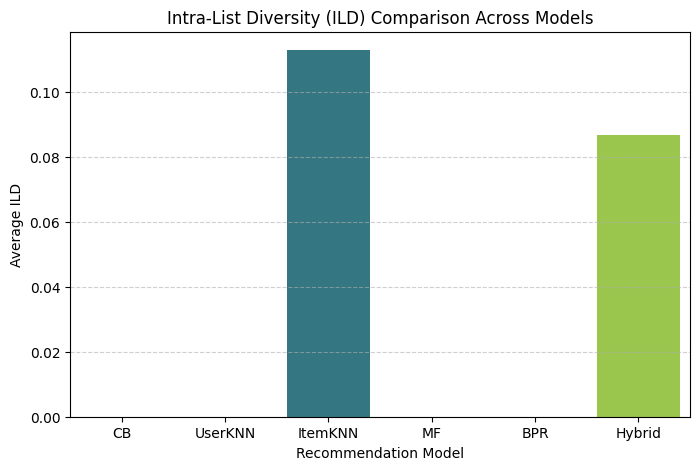

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.barplot(data=results_ild, x='Model', y='Intra-List Diversity', palette='viridis')
plt.title('Intra-List Diversity (ILD) Comparison Across Models')
plt.ylabel('Average ILD')
plt.xlabel('Recommendation Model')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

## Novelty (surprisal)

Measure each item’s novelty as:

[
\text{novelty}(i)=-\log_2 p(i)
\quad\text{with}\quad
p(i)=\frac{#\text{interactions on }i}{\text{total interactions}}
]

A user’s novelty is the **mean** surprisal of the items in their recommended list, and finally average across users.

### Item popularity

In [ ]:
def build_item_popularity(train_df):
    """
    Returns:
      pop: pd.Series indexed by item_id with p(i) in [0,1]
    """
    item_counts = train_df['item_id'].value_counts().sort_index()
    total = item_counts.sum()
    pop = item_counts / total
    # also ensure every known item appears (even if 0 in train subset)
    all_items = train_df['item_id'].unique()
    pop = pop.reindex(sorted(all_items), fill_value=0.0)
    return pop

### Item surprisal

In [ ]:
def build_item_surprisal(pop, eps=1e-12):
    """
    novelty(i) = -log2(pop(i) + eps)  (in bits)
    """
    return -np.log2(pop + eps)

### Example build from training split

In [ ]:
item_pop = build_item_popularity(train_data)
item_surprisal = build_item_surprisal(item_pop)

print("Example surprisal (higher = more novel):")
display(item_surprisal.sample(5).to_frame("novelty_bits"))

Example surprisal (higher = more novel):


,novelty_bits
item_id,
1311,12.506353
636,10.035047
476,9.442222
735,9.380822
734,12.058894


## Calibration

## Fairness metrics